In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import gzip
from pybedtools import BedTool
import os
from tqdm import tqdm
from scipy.stats import zscore
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr

from sklearn.preprocessing import OneHotEncoder
from scipy.special import logit, expit
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm 
import pybedtools
from pybedtools import BedTool

In [2]:
braaksc_pvals = pd.read_csv('../code/alzheimer_tables/Braaksc_linear_regression_pvals.tab.gz', sep='\t', index_col = 0)
braaksc_beta = pd.read_csv('../code/alzheimer_tables/Braaksc_linear_regression_beta.tab.gz', sep='\t', index_col = 0)
braaksc_zscore = pd.read_csv('../code/alzheimer_tables/Braaksc_linear_regression_zscore.tab.gz', sep='\t', index_col = 0)

In [3]:
ad_pvals = pd.read_csv('../code/alzheimer_tables/AD_logistic_regression_pvals.tab.gz', sep='\t', index_col = 0)
ad_beta = pd.read_csv('../code/alzheimer_tables/AD_logistic_regression_beta.tab.gz', sep='\t', index_col = 0)
ad_zscore = pd.read_csv('../code/alzheimer_tables/AD_logistic_regression_zscore.tab.gz', sep='\t', index_col = 0)

In [4]:
EL = pd.read_csv('../code/ebpmf_models/gao_models/tables/snmf5_EL.tab.gz', sep='\t', index_col=3)
EL[EL.columns[5:]]# col_names = TRUE) %>%
  # column_to_rownames(var = "pid")  # Replace 'column_name' with the actual name of the index column (the 4th column)

,R1015854-AC,R1015854-PCC,R1018391-AC,R1018391-PCC,R1020037-PCC,R1022980-AC,R1028639-AC,R1028639-PCC,R1039781-AC,R1039781-PCC,...,R9940994-PCC,R9950567-AC,R9950567-PCC,R9976232-AC,R9976232-PCC,R9991313-AC,R9991313-DLPFC,R9991313-PCC,R9996478-AC,R9996478-DLPFC
pid,,,,,,,,,,,,,,,,,,,,,
ENSG00000148123.factor_1,0.0392,0.1919,0.2118,0.2888,0.0004,0.7712,0.0583,0.0002,0.2627,0.1345,...,0.1024,0.0912,0.0002,0.2439,0.2641,0.3273,0.0002,0.1925,0.0374,0.0003
ENSG00000148123.factor_2,0.3411,0.1665,0.2135,0.1168,0.5187,0.0185,0.3102,0.1403,0.1722,0.1142,...,0.1994,0.1934,0.2882,0.5202,0.0716,0.3341,0.1151,0.1562,0.0813,0.2865
ENSG00000148123.factor_3,0.0631,0.0116,0.2080,0.0002,0.0659,0.0325,0.5222,0.0002,0.2833,0.4789,...,0.0957,0.5819,0.2754,0.0693,0.1688,0.0252,0.3058,0.0003,0.4575,0.0003
ENSG00000148123.factor_4,0.3346,0.4567,0.3377,0.2509,0.0004,0.0001,0.0000,0.0002,0.1195,0.0001,...,0.1928,0.0457,0.0002,0.1324,0.0335,0.2059,0.1989,0.3096,0.3365,0.3720
ENSG00000148123.factor_5,0.2219,0.1733,0.0290,0.3434,0.4147,0.1777,0.1092,0.8591,0.1622,0.2722,...,0.4096,0.0878,0.4360,0.0342,0.4620,0.1075,0.3799,0.3414,0.0873,0.3409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000170006.factor_1,0.0003,0.9972,NaN,NaN,NaN,0.0003,0.0003,0.0004,NaN,0.5092,...,0.0004,0.1468,0.0004,0.0004,0.0005,0.0004,0.0004,0.0004,NaN,NaN
ENSG00000170006.factor_2,0.3962,0.0014,NaN,NaN,NaN,0.9988,0.9988,0.0011,NaN,0.4893,...,0.7290,0.8526,0.0010,0.9984,0.1843,0.9985,0.0012,0.0011,NaN,NaN
ENSG00000170006.factor_3,0.0004,0.0005,NaN,NaN,NaN,0.0003,0.0003,0.0004,NaN,0.0005,...,0.0004,0.0002,0.9979,0.0004,0.0005,0.0004,0.0004,0.9977,NaN,NaN


In [5]:
samples = EL.columns[5:]

metadata = pd.read_csv('../code/gao_data/metadata/merged_metadata.tab.gz', sep='\t', index_col=0)

ad_samples = pd.Index(metadata.loc[metadata.cogdx == 4].index).intersection(samples)
control_samples = pd.Index(metadata.loc[metadata.cogdx == 1].index).intersection(samples)

ad_control_samples = list(ad_samples) + list(control_samples)

dlpc_samples = pd.Index(metadata.loc[metadata.tissue_id == 'DLPC'].index).intersection(samples)
ac_samples = pd.Index(metadata.loc[metadata.tissue_id == 'AC'].index).intersection(samples)
pcc_samples = pd.Index(metadata.loc[metadata.tissue_id == 'PCC'].index).intersection(samples)

X = EL[EL.columns[5:]]

In [6]:
braaksc_pvals['FDR'] = fdrcorrection(np.array(braaksc_pvals.ACAT_pval))[1]
ad_pvals['FDR'] = fdrcorrection(np.array(ad_pvals.ACAT_pval))[1]

In [7]:
# braaksc_beta.loc[gene, min_factor]

In [8]:
from scipy.stats import rankdata
from scipy.stats import norm
from sklearn.impute import SimpleImputer
import sys

def qqnorm(x):
    n=len(x)
    a=3.0/8.0 if n<=10 else 0.5
    return(norm.ppf( (rankdata(x)-a)/(n+1.0-2.0*a) ))



In [9]:
braaksc_0 = metadata.loc[metadata.braaksc == 0].index.intersection(X.columns)
braaksc_1 = metadata.loc[metadata.braaksc == 1].index.intersection(X.columns)
braaksc_2 = metadata.loc[metadata.braaksc == 2].index.intersection(X.columns)
braaksc_3 = metadata.loc[metadata.braaksc == 3].index.intersection(X.columns)
braaksc_4 = metadata.loc[metadata.braaksc == 4].index.intersection(X.columns)
braaksc_5 = metadata.loc[metadata.braaksc == 5].index.intersection(X.columns)
braaksc_6 = metadata.loc[metadata.braaksc == 6].index.intersection(X.columns)

# braaksc_0_ir = [x for x in braaksc_0_ir if not (x is np.nan)]
# braaksc_1_ir = [x for x in braaksc_1_ir if not (x is np.nan)]
# braaksc_2_ir = [x for x in braaksc_2_ir if not (x is np.nan)]
# braaksc_3_ir = [x for x in braaksc_3_ir if not (x is np.nan)]
# braaksc_4_ir = [x for x in braaksc_4_ir if not (x is np.nan)]
# braaksc_5_ir = [x for x in braaksc_5_ir if not (x is np.nan)]
# braaksc_6_ir = [x for x in braaksc_6_ir if not (x is np.nan)]

In [10]:
braaksc_0

Index(['R3081601-AC', 'R9818080-AC', 'R7039412-AC', 'R2529284-AC',
       'R1924801-AC', 'R5415701-AC', 'R6665276-AC', 'R2529284-DLPFC',
       'R2171619-DLPFC', 'R7063792-DLPFC', 'R9818080-PCC', 'R7039412-PCC',
       'R2529284-PCC', 'R7063792-PCC', 'R1924801-PCC', 'R5415701-PCC',
       'R6665276-PCC'],
      dtype='object')

In [21]:
# plt.boxplot([braaksc_0_ir,braaksc_1_ir, braaksc_2_ir, braaksc_3_ir, braaksc_4_ir, braaksc_5_ir, braaksc_6_ir])

In [22]:
# np.nanmean(braaksc_6_ir)

In [11]:
annot = pd.read_csv('../code/ebpmf_models/gao_models/tables/annotated.snmf_5.tab.gz', sep='\t',
                   names = [])
second_annot = pd.read_csv('../code/ebpmf_models/gao_models/tables/second_annotation.snmf_5.merged_isoforms.tab.gz', sep='\t',
                          names = ['gene_id', 'transcript_id', 'chain_annot', 'annot_transcript', 'intron_retention', 'utr'])
isoforms = pd.read_csv('../code/ebpmf_models/gao_models/tables/snmf_5.merged_isoforms.exons.sorted.bed.gz', sep='\t',
                      names = ['chrom', 'start', 'end', 'gene_id', 'transcript_id', 'strand', 'factor', 'exon'])

In [12]:
isoforms = pd.read_csv('../code/ebpmf_models/gao_models/tables/snmf_5.merged_isoforms.exons.sorted.bed.gz', sep='\t',
                      names = ['chrom', 'start', 'end', 'gene_id', 'transcript_id', 'strand', 'factor', 'exon'])

gencode = pd.read_csv('../code/Annotations/gencode.v44.primary_assembly.exons.sorted.bed.gz', sep='\t', 
                     names = ['chrom', 'start', 'end', 'gene', 'transcript', 'strand', 'exon', 'score', 'gencode_annot', 
                              'ensembl', 'mane', 'appris', 'annotation'])

In [13]:
# ir_total = 0
# beta = []
# braaksc_0_ir = []
# braaksc_1_ir = []
# braaksc_2_ir = []
# braaksc_3_ir = []
# braaksc_4_ir = []
# braaksc_5_ir = []
# braaksc_6_ir = []
# for gene, row in tqdm(ad_pvals.loc[ad_pvals.FDR <= 1e-4].iterrows(), leave=True, position = 0):
#     try:
#         x = row.loc[[f'factor_{str(i+1)}' for i in range(5)]]
#         min_factors = x.index
#         # min_factor = x.index[x.argmin()]
#         for min_factor in min_factors:
#             p = x.loc[min_factor]
#             if p <= 1e-4:
#                 aver = isoforms.loc[(isoforms.gene_id == gene) & (isoforms.factor.apply(lambda x: min_factor in x))].transcript_id.iloc[0]
#                 is_ir = (second_annot.loc[second_annot.transcript_id == aver].intron_retention.isin(['unannotated.intron_retention', 'annotated.intron_retention'])).sum()
#                 ir_total += is_ir
        
#                 if is_ir == 1:
#                     y = X.loc[f'{gene}.{min_factor}']
#                     braaksc_0_ir.append(y.loc[braaksc_0].mean())
#                     braaksc_1_ir.append(y.loc[braaksc_1].mean())
#                     braaksc_2_ir.append(y.loc[braaksc_2].mean())
#                     braaksc_3_ir.append(y.loc[braaksc_3].mean())
#                     braaksc_4_ir.append(y.loc[braaksc_4].mean())
#                     braaksc_5_ir.append(y.loc[braaksc_5].mean())
#                     braaksc_6_ir.append(y.loc[braaksc_6].mean())
                    
#                     beta_ir = braaksc_zscore.loc[gene, min_factor]
#                     beta.append(beta_ir)
#     except:
#         continue

In [36]:
ir_total = 0
beta_list = []
ad_beta_list = []
zscore_list = []
braaksc_0_ir = []
braaksc_1_ir = []
braaksc_2_ir = []
braaksc_3_ir = []
braaksc_4_ir = []
braaksc_5_ir = []
braaksc_6_ir = []

braaksc_0_ir_ac = []
braaksc_1_ir_ac = []
braaksc_2_ir_ac = []
braaksc_3_ir_ac = []
braaksc_4_ir_ac = []
braaksc_5_ir_ac = []
braaksc_6_ir_ac = []

braaksc_0_ir_dlpc = []
braaksc_1_ir_dlpc = []
braaksc_2_ir_dlpc = []
braaksc_3_ir_dlpc = []
braaksc_4_ir_dlpc = []
braaksc_5_ir_dlpc = []
braaksc_6_ir_dlpc = []

braaksc_0_ir_pcc = []
braaksc_1_ir_pcc = []
braaksc_2_ir_pcc = []
braaksc_3_ir_pcc = []
braaksc_4_ir_pcc = []
braaksc_5_ir_pcc = []
braaksc_6_ir_pcc = []
isoform_list = []

FDR_list = []
pval_list = []

gene_list = []


for gene, row in tqdm(ad_pvals.loc[ad_pvals.FDR <= 5e-2].iterrows(), leave=True, position = 0):
    try:
        x = row.loc[[f'factor_{str(i+1)}' for i in range(5)]]
        min_factors = x.index
        min_factor = x.index[x.argmin()]
        # for min_factor in min_factors:
        aver = isoforms.loc[(isoforms.gene_id == gene) & (isoforms.factor.apply(lambda x: min_factor in x))].transcript_id.iloc[0]
        
        is_ir = (second_annot.loc[second_annot.transcript_id == aver].intron_retention.isin(['unannotated.intron_retention', 'annotated.intron_retention'])).sum()
        ir_total += is_ir

        if is_ir == 1:
            isoform_list.append(aver)
            
            FDR_list.append(row.FDR)
            pval_list.append(x.loc[min_factor])
            y = X.loc[f'{gene}.{min_factor}']
            braaksc_0_ir.append(y.loc[braaksc_0].mean())
            braaksc_1_ir.append(y.loc[braaksc_1].mean())
            braaksc_2_ir.append(y.loc[braaksc_2].mean())
            braaksc_3_ir.append(y.loc[braaksc_3].mean())
            braaksc_4_ir.append(y.loc[braaksc_4].mean())
            braaksc_5_ir.append(y.loc[braaksc_5].mean())
            braaksc_6_ir.append(y.loc[braaksc_6].mean())


            braaksc_0_ir_ac.append(y.loc[braaksc_0.intersection(ac_samples)].mean())
            braaksc_1_ir_ac.append(y.loc[braaksc_1.intersection(ac_samples)].mean())
            braaksc_2_ir_ac.append(y.loc[braaksc_2.intersection(ac_samples)].mean())
            braaksc_3_ir_ac.append(y.loc[braaksc_3.intersection(ac_samples)].mean())
            braaksc_4_ir_ac.append(y.loc[braaksc_4.intersection(ac_samples)].mean())
            braaksc_5_ir_ac.append(y.loc[braaksc_5.intersection(ac_samples)].mean())
            braaksc_6_ir_ac.append(y.loc[braaksc_6.intersection(ac_samples)].mean())

            braaksc_0_ir_pcc.append(y.loc[braaksc_0.intersection(pcc_samples)].mean())
            braaksc_1_ir_pcc.append(y.loc[braaksc_1.intersection(pcc_samples)].mean())
            braaksc_2_ir_pcc.append(y.loc[braaksc_2.intersection(pcc_samples)].mean())
            braaksc_3_ir_pcc.append(y.loc[braaksc_3.intersection(pcc_samples)].mean())
            braaksc_4_ir_pcc.append(y.loc[braaksc_4.intersection(pcc_samples)].mean())
            braaksc_5_ir_pcc.append(y.loc[braaksc_5.intersection(pcc_samples)].mean())
            braaksc_6_ir_pcc.append(y.loc[braaksc_6.intersection(pcc_samples)].mean())

            braaksc_0_ir_dlpc.append(y.loc[braaksc_0.intersection(dlpc_samples)].mean())
            braaksc_1_ir_dlpc.append(y.loc[braaksc_1.intersection(dlpc_samples)].mean())
            braaksc_2_ir_dlpc.append(y.loc[braaksc_2.intersection(dlpc_samples)].mean())
            braaksc_3_ir_dlpc.append(y.loc[braaksc_3.intersection(dlpc_samples)].mean())
            braaksc_4_ir_dlpc.append(y.loc[braaksc_4.intersection(dlpc_samples)].mean())
            braaksc_5_ir_dlpc.append(y.loc[braaksc_5.intersection(dlpc_samples)].mean())
            braaksc_6_ir_dlpc.append(y.loc[braaksc_6.intersection(dlpc_samples)].mean())

            z_ir = braaksc_zscore.loc[gene, min_factor]
            beta_ir = braaksc_beta.loc[gene, min_factor]
            beta_list.append(beta_ir)

            ad_beta_ir = ad_beta.loc[gene, min_factor]
            ad_beta_list.append(ad_beta_ir)
            zscore_list.append(z_ir)

            gene_list.append(gene)
    except:
        continue

4943it [08:47,  9.37it/s]


In [37]:
ad_boxplot = pd.DataFrame()
ad_boxplot['gene'] = ((gene_list)*7)*4
ad_boxplot['isoform'] = ((isoform_list)*7)*4
braaksc_all_list = braaksc_0_ir + braaksc_1_ir + braaksc_2_ir + braaksc_3_ir + braaksc_4_ir + braaksc_5_ir + braaksc_6_ir
braaksc_all_list += braaksc_0_ir_ac + braaksc_1_ir_ac + braaksc_2_ir_ac + braaksc_3_ir_ac + braaksc_4_ir_ac + braaksc_5_ir_ac + braaksc_6_ir_ac
braaksc_all_list += braaksc_0_ir_dlpc + braaksc_1_ir_dlpc + braaksc_2_ir_dlpc + braaksc_3_ir_dlpc 
braaksc_all_list += braaksc_4_ir_dlpc + braaksc_5_ir_dlpc + braaksc_6_ir_dlpc
braaksc_all_list += braaksc_0_ir_pcc + braaksc_1_ir_pcc + braaksc_2_ir_pcc + braaksc_3_ir_pcc + braaksc_4_ir_pcc + braaksc_5_ir_pcc + braaksc_6_ir_pcc
ad_boxplot['loadings'] = braaksc_all_list
braaksc_ = [0]*len(braaksc_0_ir) + [1]*len(braaksc_1_ir) + [2]*len(braaksc_2_ir) + [3]*len(braaksc_3_ir) + [4]*len(braaksc_4_ir)
braaksc_ += [5]*len(braaksc_5_ir) + [6]*len(braaksc_6_ir) 
braaksc_ = (braaksc_) * 4
ad_boxplot['braaksc'] = braaksc_
ad_boxplot['FDR'] = ((FDR_list)*7)*4
tissue_list = (['all_tissues'] * len(braaksc_0_ir))*7
tissue_list += (['AC'] * len(braaksc_0_ir))*7
tissue_list += (['DLPC'] * len(braaksc_0_ir))*7
tissue_list += (['PCC'] * len(braaksc_0_ir))*7
ad_boxplot['tissue'] = tissue_list

ad_boxplot['beta'] = ((beta_list)*7)*4

ad_boxplot['ad_beta'] = ((ad_beta_list)*7)*4
ad_boxplot['zscore'] = ((zscore_list)*7)*4

In [38]:
ad_boxplot.to_csv('../code/intron_retention.AD_dataframe.tab.gz', sep='\t', index=False, header=True)
# ad_boxplot = pd.read_csv('../code/intron_retention.AD_dataframe.tab.gz', sep='\t')

In [39]:
ad_boxplot

,gene,isoform,loadings,braaksc,FDR,tissue,beta,ad_beta,zscore
0,ENSG00000148123,ENSG00000148123.isoform_2,0.452594,0,0.044029,all_tissues,-0.011765,-1.146892,-2.205492
1,ENSG00000176155,ENSG00000176155.isoform_1,0.074671,0,0.000211,all_tissues,0.012402,2.335530,2.752517
2,ENSG00000205209,ENSG00000205209.isoform_1,0.169847,0,0.023469,all_tissues,0.005665,1.590025,1.382420
3,ENSG00000101935,ENSG00000101935.isoform_2,0.242265,0,0.004806,all_tissues,-0.010587,-2.557261,-3.249018
4,ENSG00000182054,ENSG00000182054.isoform_2,0.036553,0,0.031578,all_tissues,0.005124,2.974948,2.314633
...,...,...,...,...,...,...,...,...,...
55211,ENSG00000168970,ENSG00000168970.isoform_3,0.347225,6,0.022094,PCC,0.004413,1.669002,1.130089
55212,ENSG00000101203,ENSG00000101203.isoform_1,0.061175,6,0.009388,PCC,0.013430,1.542742,2.648980
55213,ENSG00000087206,ENSG00000087206.isoform_3,0.257225,6,0.036959,PCC,0.003022,1.537936,0.743802
55214,ENSG00000159592,ENSG00000159592.isoform_3,0.241300,6,0.014187,PCC,0.007408,2.368337,2.444691


In [42]:
ir_total = 0
beta_list = []
ad_beta_list = []
zscore_list = []
braaksc_0_ir = []
braaksc_1_ir = []
braaksc_2_ir = []
braaksc_3_ir = []
braaksc_4_ir = []
braaksc_5_ir = []
braaksc_6_ir = []

braaksc_0_ir_ac = []
braaksc_1_ir_ac = []
braaksc_2_ir_ac = []
braaksc_3_ir_ac = []
braaksc_4_ir_ac = []
braaksc_5_ir_ac = []
braaksc_6_ir_ac = []

braaksc_0_ir_dlpc = []
braaksc_1_ir_dlpc = []
braaksc_2_ir_dlpc = []
braaksc_3_ir_dlpc = []
braaksc_4_ir_dlpc = []
braaksc_5_ir_dlpc = []
braaksc_6_ir_dlpc = []

braaksc_0_ir_pcc = []
braaksc_1_ir_pcc = []
braaksc_2_ir_pcc = []
braaksc_3_ir_pcc = []
braaksc_4_ir_pcc = []
braaksc_5_ir_pcc = []
braaksc_6_ir_pcc = []
isoform_list = []

FDR_list = []
pval_list = []

gene_list = []


for gene, row in tqdm(ad_pvals.loc[ad_pvals.FDR <= 5e-2].iterrows(), leave=True, position = 0):
    try:
        x = row.loc[[f'factor_{str(i+1)}' for i in range(5)]]
        # min_factors = x.index
        # min_factor = x.index[x.argmin()]

        min_factors = x.index
        first_min = x.min()
        second_min_factor = x[x != first_min].idxmin()

        
        # for min_factor in min_factors:
        aver = isoforms.loc[(isoforms.gene_id == gene) & (isoforms.factor.apply(lambda x: second_min_factor in x))].transcript_id.iloc[0]
        
        is_ir = (second_annot.loc[second_annot.transcript_id == aver].intron_retention.isin(['unannotated.intron_retention', 'annotated.intron_retention'])).sum()
        ir_total += is_ir

        if is_ir == 1:
            isoform_list.append(aver)
            
            FDR_list.append(row.FDR)
            pval_list.append(x.loc[second_min_factor])
            y = X.loc[f'{gene}.{second_min_factor}']
            braaksc_0_ir.append(y.loc[braaksc_0].mean())
            braaksc_1_ir.append(y.loc[braaksc_1].mean())
            braaksc_2_ir.append(y.loc[braaksc_2].mean())
            braaksc_3_ir.append(y.loc[braaksc_3].mean())
            braaksc_4_ir.append(y.loc[braaksc_4].mean())
            braaksc_5_ir.append(y.loc[braaksc_5].mean())
            braaksc_6_ir.append(y.loc[braaksc_6].mean())


            braaksc_0_ir_ac.append(y.loc[braaksc_0.intersection(ac_samples)].mean())
            braaksc_1_ir_ac.append(y.loc[braaksc_1.intersection(ac_samples)].mean())
            braaksc_2_ir_ac.append(y.loc[braaksc_2.intersection(ac_samples)].mean())
            braaksc_3_ir_ac.append(y.loc[braaksc_3.intersection(ac_samples)].mean())
            braaksc_4_ir_ac.append(y.loc[braaksc_4.intersection(ac_samples)].mean())
            braaksc_5_ir_ac.append(y.loc[braaksc_5.intersection(ac_samples)].mean())
            braaksc_6_ir_ac.append(y.loc[braaksc_6.intersection(ac_samples)].mean())

            braaksc_0_ir_pcc.append(y.loc[braaksc_0.intersection(pcc_samples)].mean())
            braaksc_1_ir_pcc.append(y.loc[braaksc_1.intersection(pcc_samples)].mean())
            braaksc_2_ir_pcc.append(y.loc[braaksc_2.intersection(pcc_samples)].mean())
            braaksc_3_ir_pcc.append(y.loc[braaksc_3.intersection(pcc_samples)].mean())
            braaksc_4_ir_pcc.append(y.loc[braaksc_4.intersection(pcc_samples)].mean())
            braaksc_5_ir_pcc.append(y.loc[braaksc_5.intersection(pcc_samples)].mean())
            braaksc_6_ir_pcc.append(y.loc[braaksc_6.intersection(pcc_samples)].mean())

            braaksc_0_ir_dlpc.append(y.loc[braaksc_0.intersection(dlpc_samples)].mean())
            braaksc_1_ir_dlpc.append(y.loc[braaksc_1.intersection(dlpc_samples)].mean())
            braaksc_2_ir_dlpc.append(y.loc[braaksc_2.intersection(dlpc_samples)].mean())
            braaksc_3_ir_dlpc.append(y.loc[braaksc_3.intersection(dlpc_samples)].mean())
            braaksc_4_ir_dlpc.append(y.loc[braaksc_4.intersection(dlpc_samples)].mean())
            braaksc_5_ir_dlpc.append(y.loc[braaksc_5.intersection(dlpc_samples)].mean())
            braaksc_6_ir_dlpc.append(y.loc[braaksc_6.intersection(dlpc_samples)].mean())

            z_ir = braaksc_zscore.loc[gene, second_min_factor]
            beta_ir = braaksc_beta.loc[gene, second_min_factor]
            beta_list.append(beta_ir)
            ad_beta_ir = ad_beta.loc[gene, second_min_factor]
            ad_beta_list.append(ad_beta_ir)
            zscore_list.append(z_ir)

            gene_list.append(gene)
    except:
        continue

4943it [08:46,  9.39it/s]


In [44]:
ad_second_boxplot = pd.DataFrame()
ad_second_boxplot['gene'] = ((gene_list)*7)*4
ad_second_boxplot['isoform'] = ((isoform_list)*7)*4
braaksc_all_list = braaksc_0_ir + braaksc_1_ir + braaksc_2_ir + braaksc_3_ir + braaksc_4_ir + braaksc_5_ir + braaksc_6_ir
braaksc_all_list += braaksc_0_ir_ac + braaksc_1_ir_ac + braaksc_2_ir_ac + braaksc_3_ir_ac + braaksc_4_ir_ac + braaksc_5_ir_ac + braaksc_6_ir_ac
braaksc_all_list += braaksc_0_ir_dlpc + braaksc_1_ir_dlpc + braaksc_2_ir_dlpc + braaksc_3_ir_dlpc 
braaksc_all_list += braaksc_4_ir_dlpc + braaksc_5_ir_dlpc + braaksc_6_ir_dlpc
braaksc_all_list += braaksc_0_ir_pcc + braaksc_1_ir_pcc + braaksc_2_ir_pcc + braaksc_3_ir_pcc + braaksc_4_ir_pcc + braaksc_5_ir_pcc + braaksc_6_ir_pcc
ad_second_boxplot['loadings'] = braaksc_all_list
braaksc_ = [0]*len(braaksc_0_ir) + [1]*len(braaksc_1_ir) + [2]*len(braaksc_2_ir) + [3]*len(braaksc_3_ir) + [4]*len(braaksc_4_ir)
braaksc_ += [5]*len(braaksc_5_ir) + [6]*len(braaksc_6_ir) 
braaksc_ = (braaksc_) * 4
ad_second_boxplot['braaksc'] = braaksc_
ad_second_boxplot['FDR'] = ((FDR_list)*7)*4
tissue_list = (['all_tissues'] * len(braaksc_0_ir))*7
tissue_list += (['AC'] * len(braaksc_0_ir))*7
tissue_list += (['DLPC'] * len(braaksc_0_ir))*7
tissue_list += (['PCC'] * len(braaksc_0_ir))*7
ad_second_boxplot['tissue'] = tissue_list

ad_second_boxplot['beta'] = ((beta_list)*7)*4
ad_second_boxplot['ad_beta'] = ((ad_beta_list)*7)*4
ad_second_boxplot['zscore'] = ((zscore_list)*7)*4

In [45]:
ad_second_boxplot = ad_second_boxplot.loc[~ad_second_boxplot.gene.isin(ad_boxplot.gene.unique())].reset_index(drop=True)

In [47]:
ad_second_boxplot.to_csv('../code/intron_retention.second_AD_dataframe.tab.gz', sep='\t', index=False, header=True)

<Axes: xlabel='tissue', ylabel='loadings'>

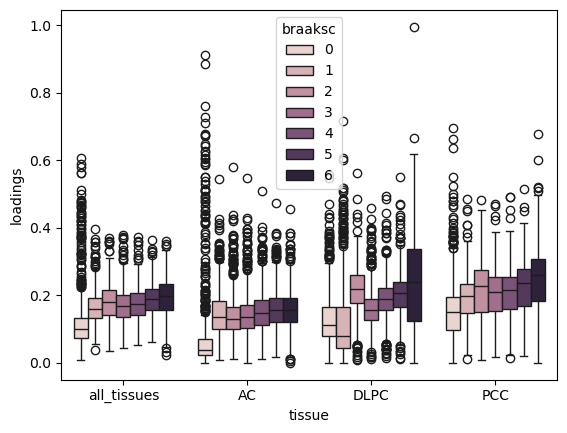

In [44]:
sns.boxplot(data = ad_boxplot.loc[(ad_boxplot.FDR <= 1e-2)], x = 'tissue', y = 'loadings', hue = 'braaksc')

In [45]:
len(ad_boxplot.loc[ad_boxplot.FDR <= 1e-2].gene.unique())

754

Text(0, 0.5, 'Intron retention\nfactor loadings')

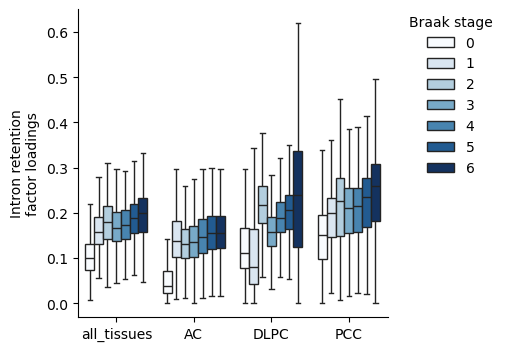

In [154]:
fig, ax = plt.subplots(figsize=(4,4))
sns.boxplot(data = ad_boxplot.loc[(ad_boxplot.FDR <= 1e-2)], x = 'tissue', y = 'loadings', hue = 'braaksc', showfliers=False,
           palette='Blues', ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, frameon=False, title='Braak stage')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('Intron retention\nfactor loadings')

# plt.savefig('../code/scratch_figures/figure5/IR_braaksc_correlation.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure5/IR_braaksc_correlation.png', bbox_inches='tight', dpi=500)

In [286]:
braaksc_0 = metadata.loc[metadata.braaksc == 0].index.intersection(X.columns)
braaksc_1 = metadata.loc[metadata.braaksc == 1].index.intersection(X.columns)
braaksc_2 = metadata.loc[metadata.braaksc == 2].index.intersection(X.columns)
braaksc_3 = metadata.loc[metadata.braaksc == 3].index.intersection(X.columns)
braaksc_4 = metadata.loc[metadata.braaksc == 4].index.intersection(X.columns)
braaksc_5 = metadata.loc[metadata.braaksc == 5].index.intersection(X.columns)
braaksc_6 = metadata.loc[metadata.braaksc == 6].index.intersection(X.columns)

braaksc_0_ir = [x for x in braaksc_0_ir_pcc if not (x is np.nan)]
braaksc_1_ir = [x for x in braaksc_1_ir_pcc if not (x is np.nan)]
braaksc_2_ir = [x for x in braaksc_2_ir_pcc if not (x is np.nan)]
braaksc_3_ir = [x for x in braaksc_3_ir_pcc if not (x is np.nan)]
braaksc_4_ir = [x for x in braaksc_4_ir_pcc if not (x is np.nan)]
braaksc_5_ir = [x for x in braaksc_5_ir_pcc if not (x is np.nan)]
braaksc_6_ir = [x for x in braaksc_6_ir_pcc if not (x is np.nan)]

In [288]:
len(braaksc_0_ir_ac)

1628

In [277]:
np.nanmedian(braaksc_0_ir_pcc)

0.15458571428571427

In [322]:
1232/len(ad_genes)

0.24924135140602874

In [186]:
import gseapy as gp
from gseapy import barplot, dotplot

In [423]:
genes_df = pd.read_csv('../data/all_genes.protein_coding.bed.gz', sep='\t', 
                       names = ['chrom', 'start', 'end', 'gene_id', 'gene_name', 'strand'])
ad_genes = ad_pvals.loc[ad_pvals.FDR <= 0.05].index
ad_gene_names = list(genes_df.loc[genes_df.gene_id.isin(ad_genes)].gene_name)

2024-09-27 22:26:59,616 [INFO] User defined gene sets is given: ../code/c5.all.v2023.1.Hs.symbols.gmt
2024-09-27 22:26:59,845 [INFO] Run: c5.all.v2023.1.Hs.symbols.gmt 
2024-09-27 22:27:09,082 [INFO] Background is not set! Use all 19384 genes in c5.all.v2023.1.Hs.symbols.gmt.
2024-09-27 22:27:14,186 [INFO] Done.


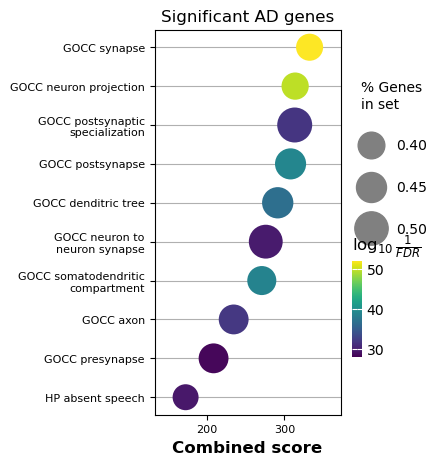

In [313]:
# GSEApy gives some annoying info messages that we don't need...
import warnings
warnings.filterwarnings("ignore")


# gene_list = list(top_genes.loc[top_genes.resid > top_genes.resid.quantile(0.75)].symbol)

enr2 = gp.enrich(gene_list=ad_gene_names, # or gene_list=glist
                 gene_sets=['../code/c5.all.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dp = dotplot(enr2.res2d, title='Top AD affected genes',cmap='viridis', size=8, figsize=(3,5))
y = ['HP absent speech', 'GOCC presynapse', 'GOCC axon', 'GOCC somatodendritic\ncompartment', 'GOCC neuron to\nneuron synapse',
     'GOCC denditric tree', 'GOCC postsynapse', 'GOCC postsynaptic\nspecialization', 'GOCC neuron projection', 'GOCC synapse']
# y = ['GOCC synapse', 'GOCC mitochondrion', 'HP language impairment', 'GOCC denditric tree', 'GOCC neuron projection', 'GOCC axon',
#      'GOCC somatodendritic\ncompartment', 'HP absent speech', 'GOBP cell-cell adhesion via\nplasma membrane\nadhesion molecules',
#      'GOBP homophilic cell-cell\nadhesion via plasma membrane\nadhesion molecules']
dp.set_yticklabels(y, size=8)
dp.set_title('Significant AD genes', size=12)
dp.set_xlabel('Combined score', size=12)
dp.set_xticks([200, 300])
dp.set_xticklabels(['200', '300'], size=8)

plt.savefig('../code/scratch_figures/figure5/GSEA_AD.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/GSEA_AD.png', bbox_inches='tight', dpi=500)

In [28]:
X = EL[EL.columns[5:]]

In [38]:
ir_total = 0
beta = []
braaksc_ad_ir = []
braaksc_ctrl_ir = []
gene_list = []

braaksc_ad_ir_ac = []
braaksc_ctrl_ir_ac = []
braaksc_ad_ir_pcc = []
braaksc_ctrl_ir_pcc = []
braaksc_ad_ir_dlpc = []
braaksc_ctrl_ir_dlpc = []


FDR_list = []
pval_list = []


for gene, row in tqdm(ad_pvals.loc[ad_pvals.FDR <= 1e-1].iterrows(), leave=True, position = 0):
    try:
        x = row.loc[[f'factor_{str(i+1)}' for i in range(5)]]
        min_factors = x.index
        min_factor = x.index[x.argmin()]
        # for min_factor in min_factors:
        aver = isoforms.loc[(isoforms.gene_id == gene) & (isoforms.factor.apply(lambda x: min_factor in x))].transcript_id.iloc[0]
        is_ir = (second_annot.loc[second_annot.transcript_id == aver].intron_retention.isin(['unannotated.intron_retention', 'annotated.intron_retention'])).sum()
        ir_total += is_ir

        if is_ir == 1:
            FDR_list.append(row.FDR)
            pval_list.append(x.loc[min_factor])
            y = X.loc[f'{gene}.{min_factor}']
            braaksc_ad_ir.append(y.loc[ad_samples].mean())
            braaksc_ctrl_ir.append(y.loc[control_samples].mean())
            


            braaksc_ad_ir_ac.append(y.loc[ad_samples.intersection(ac_samples)].mean())
            braaksc_ctrl_ir_ac.append(y.loc[control_samples.intersection(ac_samples)].mean())

            braaksc_ad_ir_pcc.append(y.loc[ad_samples.intersection(pcc_samples)].mean())
            braaksc_ctrl_ir_pcc.append(y.loc[control_samples.intersection(pcc_samples)].mean())

            braaksc_ad_ir_dlpc.append(y.loc[ad_samples.intersection(dlpc_samples)].mean())
            braaksc_ctrl_ir_dlpc.append(y.loc[control_samples.intersection(dlpc_samples)].mean())
            
            beta_ir = braaksc_zscore.loc[gene, min_factor]
            beta.append(beta_ir)
            gene_list.append(gene)
    except:
        continue

6663it [14:07,  7.86it/s]


In [40]:
ad_boxplot_ = pd.DataFrame()
ad_boxplot_['gene'] = ((gene_list)*2)*4
braaksc_all_list = braaksc_ad_ir + braaksc_ctrl_ir
braaksc_all_list += braaksc_ad_ir_ac + braaksc_ctrl_ir_ac 
braaksc_all_list += braaksc_ad_ir_dlpc + braaksc_ctrl_ir_dlpc
braaksc_all_list += braaksc_ad_ir_pcc + braaksc_ctrl_ir_pcc
ad_boxplot_['loadings'] = braaksc_all_list
ad_ = ['AD']*len(braaksc_ad_ir) + ['control']*len(braaksc_ctrl_ir) 
ad_ = (ad_) * 4
ad_boxplot_['AD'] = ad_
ad_boxplot_['FDR'] = ((FDR_list)*2)*4
tissue_list = (['all_tissues'] * len(braaksc_ad_ir))*2
tissue_list += (['AC'] * len(braaksc_ad_ir))*2
tissue_list += (['DLPC'] * len(braaksc_ad_ir))*2
tissue_list += (['PCC'] * len(braaksc_ad_ir))*2
ad_boxplot_['tissue'] = tissue_list

In [50]:
ad_boxplot_.to_csv('../code/intron_retention.AD_v_control_dataframe.tab.gz', sep='\t', index=False, header=True)

<Axes: xlabel='tissue', ylabel='loadings'>

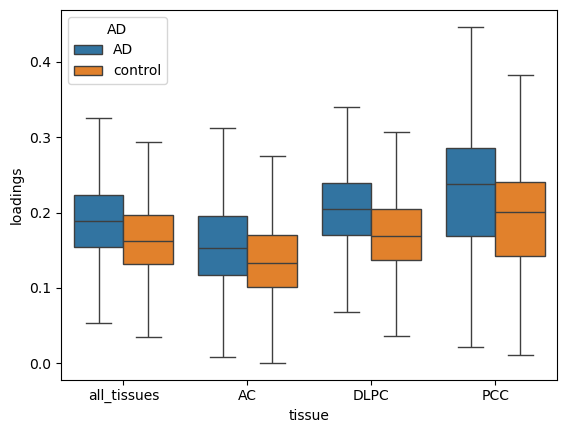

In [42]:
sns.boxplot(data = ad_boxplot_.loc[ad_boxplot_.FDR <= 5e-2], x = 'tissue', y = 'loadings', hue = 'AD', showfliers=False)

In [43]:
gvc1 = pd.read_csv('../code/GVC_table1.tsv', sep='\t', skiprows=2, names = ['number', 'chrom', 'location', 'snv', 'gene'])
gvc2 = pd.read_csv('../code/GVC_table2.tsv', sep='\t', skiprows=2, names = ['number', 'gene', 'source', 'location'])
ru_extended = pd.read_csv('../code/overlap.min_corr_gwas95_qtl70.genelist.csv')

ad_genes_ru = pd.Index(gvc1.gene).union(pd.Index(gvc2.gene))
ad_gene_ru_id = pd.Index(genes_df.loc[genes_df.gene_name.isin(ad_genes_ru)].gene_id)

In [48]:
ad_genes_ru = pd.Index(gvc1.gene).union(pd.Index(gvc2.gene))
ad_gene_ru_id = pd.Index(genes_df.loc[genes_df.gene_name.isin(ad_genes_ru)].gene_id)

<Axes: xlabel='tissue', ylabel='loadings'>

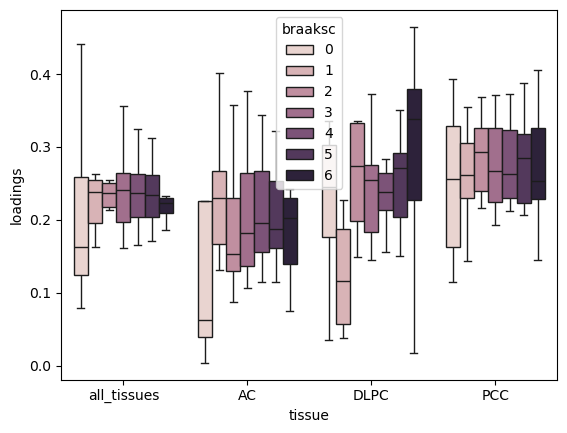

In [49]:
sns.boxplot(data = ad_boxplot.loc[ad_boxplot.gene.isin(ad_gene_ru_id)], x = 'tissue', y = 'loadings', hue = 'braaksc', showfliers=False)

<Axes: xlabel='tissue', ylabel='loadings'>

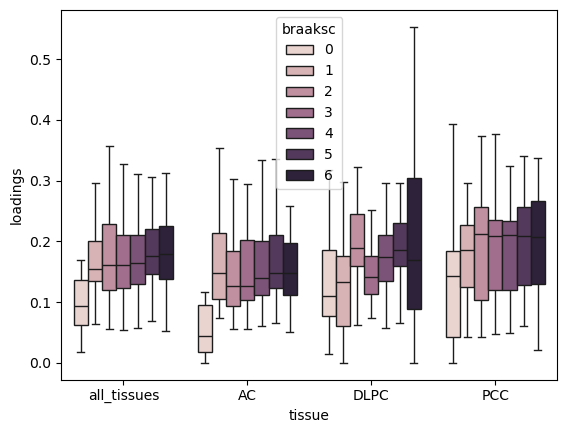

In [46]:
sns.boxplot(data = ad_boxplot.loc[ad_boxplot.gene.isin(list(ru_extended.region))], x = 'tissue', y = 'loadings', hue = 'braaksc', showfliers=False)

In [466]:
ad_boxplot.loc[ad_boxplot.gene.isin(ad_gene_ru_id) & (ad_boxplot.braaksc == 0) & (ad_boxplot.tissue == 'AC')].sort_values('FDR')

,gene,loadings,braaksc,FDR,tissue
12711,ENSG00000127415,0.043514,0,0.005581,AC
12051,ENSG00000153814,0.559843,0,0.013191,AC
12525,ENSG00000154122,0.065129,0,0.022267,AC
12524,ENSG00000157368,0.027371,0,0.032466,AC
12964,ENSG00000113108,0.584043,0,0.036312,AC
12097,ENSG00000086289,0.060971,0,0.064120,AC
12302,ENSG00000249853,0.114771,0,0.080267,AC
11505,ENSG00000087589,0.003843,0,0.088738,AC


ENSG00000127415


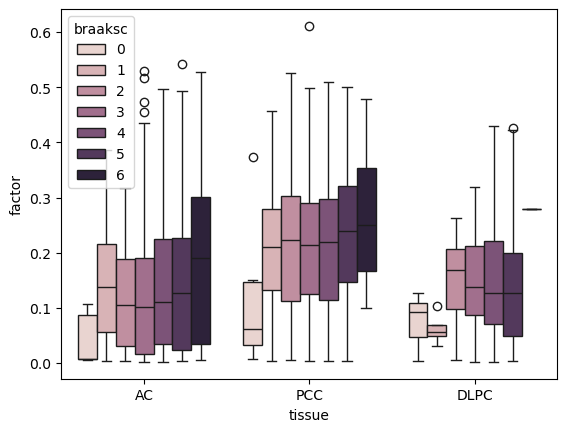

ENSG00000153814


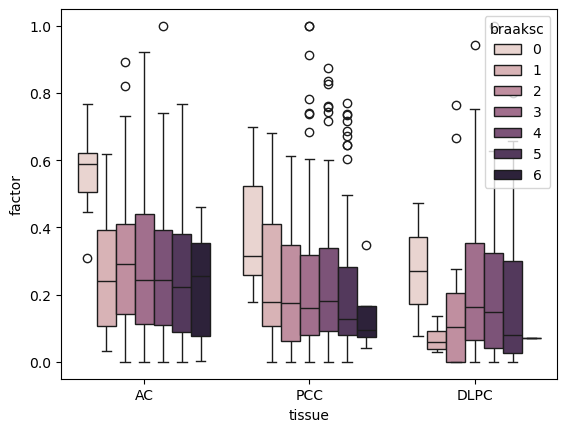

ENSG00000154122


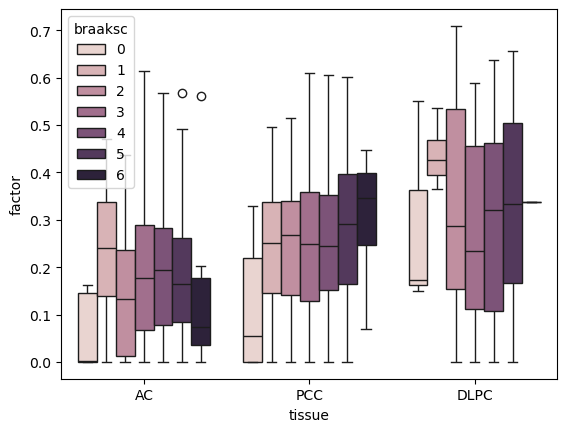

ENSG00000157368


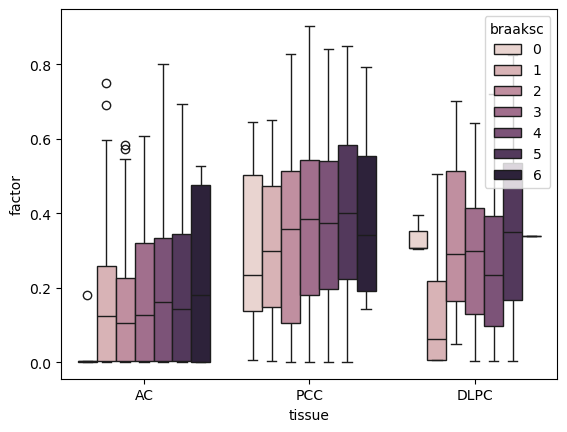

ENSG00000113108


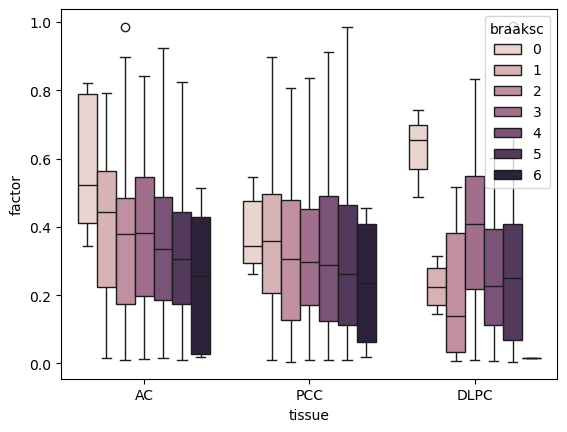

ENSG00000086289


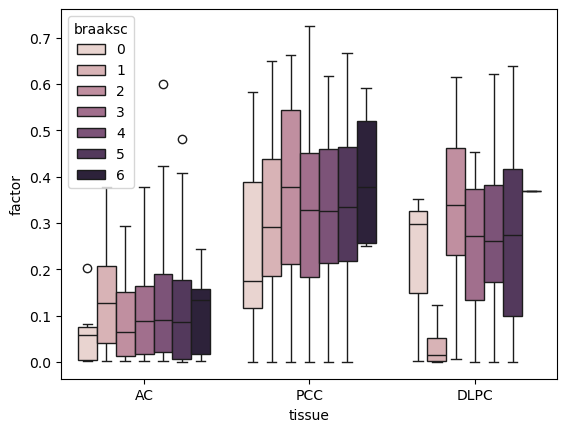

ENSG00000249853


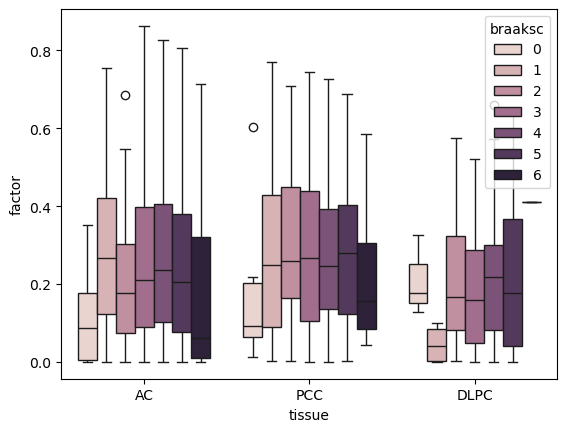

ENSG00000087589


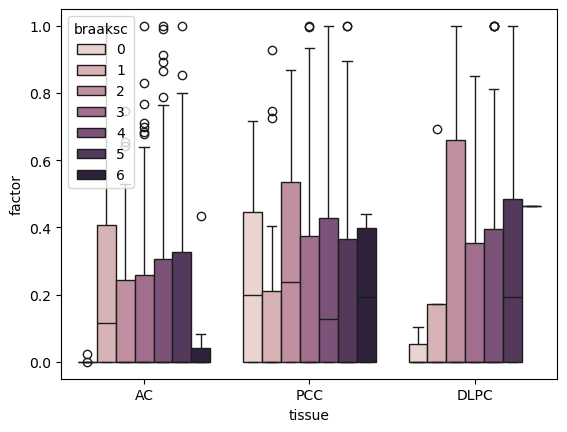

In [469]:
for gene in ad_boxplot.loc[ad_boxplot.gene.isin(ad_gene_ru_id) & (ad_boxplot.braaksc == 0) & (ad_boxplot.tissue == 'AC')].sort_values('FDR').gene:
    print(gene)
    factor_ = [f'factor_{str(i+1)}' for i in range(5)][ad_pvals.loc[gene, [f'factor_{str(i+1)}' for i in range(5)]].argmin()]
    factor_df = pd.DataFrame()
    factor_df['factor'] = np.array(EL.loc[f'{gene}.{factor_}', samples])
    factor_df['tissue'] = list(metadata.loc[samples, 'tissue_id'])
    factor_df['braaksc'] = list(metadata.loc[samples, 'braaksc'])
    sns.boxplot(data = factor_df, x = 'tissue', y = 'factor', hue = 'braaksc')
    plt.show()

In [464]:
ad_pvals.loc[gene, [f'factor_{str(i+1)}' for i in range(5)]]

factor_1    0.247410
factor_2    0.492494
factor_3    0.562930
factor_4    0.090196
factor_5    0.000590
Name: ENSG00000090054, dtype: float64

In [465]:
gene

'ENSG00000090054'

In [352]:

import rpy2
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import rpy2.robjects.packages as rpackages


def load_ebpmf_gene(gene_id, n):
    readRDS = ro.r['readRDS']
    df = readRDS(f'/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/gao_models/RDS/{str(n)}/{gene_id}.rds')
    with (ro.default_converter + pandas2ri.converter).context():
        pd_from_r_df = ro.conversion.get_conversion().rpy2py(df)

    output = pd_from_r_df

    return output


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


In [425]:
rds = load_ebpmf_gene('ENSG00000113108', 1306)

In [37]:
metadata_test = metadata.loc[EL.columns.intersection(metadata.index)]

In [ ]:
gencode_bed, gencode_full_gene = get_gencode_bed(gencode, 'ENSG00000148123')
torino_bed = BedTool.from_dataframe(isoforms.loc[isoforms.transcript_id == 'ENSG00000148123.isoform_2'])
IR_bed = get_IR_bed(torino_bed, gencode_bed, gencode_full_gene)

In [38]:
fh = gzip.open('../code/gao_data/counts/ENSG00000148123.csv.gz')
coords = fh.readline()
coords_int = [int(x.split(':')[1]) for x in coords.decode().rstrip().split(',')[1:]]
intron_idx, meta_samples = get_plotting_averages2('ENSG00000148123.isoform_2', IR_bed, metadata_test, coords_int, fh)

2455it [02:32, 16.08it/s]


In [91]:
for idx, df in ad_boxplot.groupby(['gene', 'isoform']):
    gene, isoform = idx
    break

In [93]:
idx

('ENSG00000000419', 'ENSG00000000419.isoform_1')

In [54]:
for intron, intron_data in intron_idx.items():
    break

In [56]:
intron_data['interval']

('chr9', 101185558, 101269879, 'ENSG00000148123')

In [122]:
zscore(np.array(intron_idx['ENSG00000148123.isoform_2.4']['coverage']))[list((meta_samples.braaksc >= 5)& (meta_samples.tissue=='PCC'))].mean()

0.2333969028884202

In [600]:
y['intron_5'] = x['ENSG00000148123.isoform_2.5']['coverage']

In [120]:
(zscore(y.loc[y.tissue=='PCC'].intron_5)[y.loc[y.tissue=='PCC'].braaksc >= 5]).mean()

AttributeError: 'Series' object has no attribute 'tissue'

In [121]:
(zscore(y.loc[y.tissue=='PCC'].intron_5[y.loc[y.tissue=='PCC'].braaksc >= 5]).mean()

SyntaxError: incomplete input (4281000962.py, line 1)

In [48]:
zscore(np.array(x['ENSG00000148123.isoform_2.5']['coverage']))[list((y.braaksc >= 6) & (y.tissue=='PCC'))]

NameError: name 'x' is not defined

In [530]:
np.sum(y[c['ENSG00000148123.isoform_2.1']['flk2']['idx']])

1

In [531]:
np.sum(c['ENSG00000148123.isoform_2.1']['flk2']['idx'])

221

In [532]:
25/(376+221)

0.04187604690117253

In [249]:
0.0027447861888515506/0.008375209380234505


0.32772747094887517

In [179]:
aver = get_counts_for_intervals(gencode_df, coords_int, counts_sample)

In [192]:
np.sum(aver[8]['in_interval'])/len(aver[3]['in_interval'])

0.2037037037037037

In [194]:
np.sum(aver[8]['flanking_after'])/len(aver[3]['flanking_after'])

0.0

In [473]:
introns_bed = pd.read_csv('../code/ebpmf_models/gao_models/tables/AD_IR_plots_1e3.bed.gz', sep='\t')
introns_bed2 = pd.read_csv('../code/ebpmf_models/gao_models/tables/AD_IR_plots_1e2.bed.gz', sep='\t')
introns_bed3 = pd.read_csv('../code/ebpmf_models/gao_models/tables/AD_IR_plots_5e2.bed.gz', sep='\t')

introns_bed = pd.concat([introns_bed, introns_bed2, introns_bed3], axis=0)
introns_bed.index = range(introns_bed.shape[0])

In [474]:
introns_bed = pd.concat([introns_bed, introns_bed2, introns_bed3], axis=0)
introns_bed.index = range(introns_bed.shape[0])

In [475]:
introns_bed#['braaks_high_zloadings.PCC'].mean()

,chrom,start,end,gene,isoform,braaks_0_loadings,braaks_0_zloadings,braaks_1_loadings,braaks_1_zloadings,braaks_2_loadings,...,ad_loadings.AC,ad_zloadings.AC,ctrl_loadings.DLPC,ctrl_zloadings.DLPC,ad_loadings.DLPC,ad_zloadings.DLPC,ctrl_loadings.PCC,ctrl_zloadings.PCC,ad_loadings.PCC,ad_zloadings.PCC
0,chr1,169803310,169804074,ENSG00000000460,ENSG00000000460.isoform_3,0.036025,-0.318603,0.050907,-0.013301,0.054710,...,0.042399,0.017652,0.057229,-0.022299,0.059416,0.016375,0.062405,-0.024867,0.064518,0.014423
1,chr1,169806089,169807790,ENSG00000000460,ENSG00000000460.isoform_3,0.130326,-0.063127,0.142141,0.054241,0.157457,...,0.102725,-0.083544,0.183348,0.018518,0.198180,0.140213,0.168130,0.044436,0.156941,-0.060286
2,chr1,169807930,169821678,ENSG00000000460,ENSG00000000460.isoform_3,0.190492,-0.077116,0.201992,0.003930,0.231965,...,0.161775,-0.015279,0.272952,0.151029,0.241420,-0.047391,0.240677,-0.013351,0.238866,-0.024337
3,chr1,169821760,169823407,ENSG00000000460,ENSG00000000460.isoform_3,0.076414,-0.200961,0.099640,0.002536,0.119938,...,0.078492,-0.035139,0.131004,0.059685,0.108171,-0.098869,0.121527,0.021620,0.117884,-0.005387
4,chr1,169823473,169827050,ENSG00000000460,ENSG00000000460.isoform_3,0.074052,0.029989,0.065164,-0.108074,0.071623,...,0.067305,0.048009,0.093856,0.108139,0.086010,-0.015881,0.078541,-0.015083,0.083467,0.064887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5888,chr1,235430805,235434203,ENSG00000284770,ENSG00000284770.isoform_2,0.036096,-0.386414,0.047240,0.095610,0.046566,...,0.039533,0.029484,0.066334,-0.000003,0.070823,0.108182,0.047245,-0.027834,0.049371,0.072352
5889,chr1,235435841,235436385,ENSG00000284770,ENSG00000284770.isoform_2,0.054236,-0.564623,0.088590,0.096721,0.083406,...,0.078045,0.035219,0.107289,-0.084032,0.127743,0.180875,0.078900,-0.139511,0.096550,0.223821
5890,chr1,235436451,235436543,ENSG00000284770,ENSG00000284770.isoform_2,0.047777,-0.433830,0.072339,-0.103257,0.081660,...,0.070913,0.006261,0.118138,-0.049659,0.146088,0.184157,0.074693,-0.107682,0.090725,0.134905
5891,chr1,235436609,235437321,ENSG00000284770,ENSG00000284770.isoform_2,0.024105,-0.660584,0.034167,-0.090625,0.036629,...,0.035093,0.078237,0.046571,0.048265,0.045191,-0.007737,0.034812,-0.071326,0.039568,0.218996


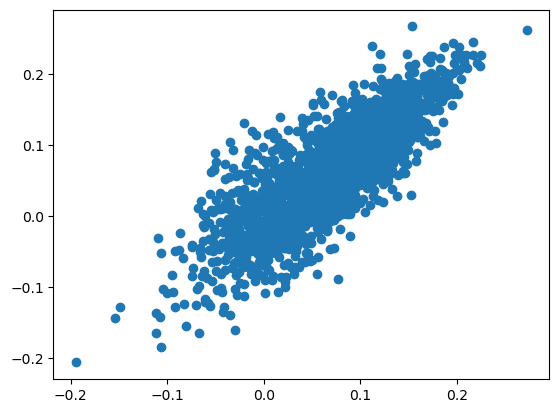

In [476]:
plt.scatter(list(introns_bed2.dropna()['ad_zloadings']), list(introns_bed2.dropna()['braaks_high_zloadings']))

In [444]:
introns_bed.dropna()['ad_zloadings'].mean()

0.07544216576287362

In [64]:
introns_bed.loc[introns_bed.gene == 'ENSG00000000460']

,chrom,start,end,gene,isoform,braaks_0_loadings,braaks_0_zloadings,braaks_1_loadings,braaks_1_zloadings,braaks_2_loadings,...,ad_loadings.AC,ad_zloadings.AC,ctrl_loadings.DLPC,ctrl_zloadings.DLPC,ad_loadings.DLPC,ad_zloadings.DLPC,ctrl_loadings.PCC,ctrl_zloadings.PCC,ad_loadings.PCC,ad_zloadings.PCC
0,chr1,169803310,169804074,ENSG00000000460,ENSG00000000460.isoform_3,0.036025,-0.318603,0.050907,-0.013301,0.054710,...,0.042399,0.017652,0.057229,-0.022299,0.059416,0.016375,0.062405,-0.024867,0.064518,0.014423
1,chr1,169806089,169807790,ENSG00000000460,ENSG00000000460.isoform_3,0.130326,-0.063127,0.142141,0.054241,0.157457,...,0.102725,-0.083544,0.183348,0.018518,0.198180,0.140213,0.168130,0.044436,0.156941,-0.060286
2,chr1,169807930,169821678,ENSG00000000460,ENSG00000000460.isoform_3,0.190492,-0.077116,0.201992,0.003930,0.231965,...,0.161775,-0.015279,0.272952,0.151029,0.241420,-0.047391,0.240677,-0.013351,0.238866,-0.024337
3,chr1,169821760,169823407,ENSG00000000460,ENSG00000000460.isoform_3,0.076414,-0.200961,0.099640,0.002536,0.119938,...,0.078492,-0.035139,0.131004,0.059685,0.108171,-0.098869,0.121527,0.021620,0.117884,-0.005387
4,chr1,169823473,169827050,ENSG00000000460,ENSG00000000460.isoform_3,0.074052,0.029989,0.065164,-0.108074,0.071623,...,0.067305,0.048009,0.093856,0.108139,0.086010,-0.015881,0.078541,-0.015083,0.083467,0.064887
5,chr1,169827841,169829262,ENSG00000000460,ENSG00000000460.isoform_3,0.064638,-0.179841,0.082786,0.066796,0.068364,...,0.069750,0.042827,0.078176,-0.017922,0.083327,0.056898,0.100495,0.088292,0.081650,-0.120751
6,chr1,169829450,169830258,ENSG00000000460,ENSG00000000460.isoform_3,0.169831,0.158383,0.157417,0.056102,0.156526,...,0.128315,0.012816,0.204097,0.188379,0.172393,-0.080806,0.180174,0.031716,0.166713,-0.068456
7,chr1,169830342,169830695,ENSG00000000460,ENSG00000000460.isoform_3,0.203319,0.400170,0.112028,-0.152147,0.154992,...,0.097805,-0.109026,0.213684,0.144108,0.171397,-0.063660,0.146158,-0.065884,0.170140,0.076242


In [59]:
def get_gencode_bed(gencode, gene):
    gencode_sub = gencode.loc[(gencode.gene == gene)].dropna()
    if gencode_sub.appris.apply(lambda x: 'appris_principal_' in x).any():
        gencode_transcript = gencode_sub.loc[gencode_sub.appris.apply(lambda x: 'appris_principal_' in x)]
    else:
        gencode_transcript = gencode_sub.loc[gencode_sub.mane == 'MANE_Select']

    gencode_bed = BedTool.from_dataframe(gencode_transcript).merge()

    gencode_full_gene = pd.DataFrame()
    gencode_full_gene['chrom'] = [gencode_transcript.iloc[0, 0]]
    gencode_full_gene['start'] = [gencode_transcript.start.min()]
    gencode_full_gene['end'] = [gencode_transcript.end.max()]

    gencode_full_gene = BedTool.from_dataframe(gencode_full_gene)
    
    return gencode_bed, gencode_full_gene


In [63]:
gencode_full_gene.to_dataframe()

,chrom,start,end
0,chr1,169795040,169854080


In [65]:
introns_bed.loc[introns_bed.gene == 'ENSG00000000460']

,chrom,start,end,gene,isoform,braaks_0_loadings,braaks_0_zloadings,braaks_1_loadings,braaks_1_zloadings,braaks_2_loadings,...,ad_loadings.AC,ad_zloadings.AC,ctrl_loadings.DLPC,ctrl_zloadings.DLPC,ad_loadings.DLPC,ad_zloadings.DLPC,ctrl_loadings.PCC,ctrl_zloadings.PCC,ad_loadings.PCC,ad_zloadings.PCC
0,chr1,169803310,169804074,ENSG00000000460,ENSG00000000460.isoform_3,0.036025,-0.318603,0.050907,-0.013301,0.054710,...,0.042399,0.017652,0.057229,-0.022299,0.059416,0.016375,0.062405,-0.024867,0.064518,0.014423
1,chr1,169806089,169807790,ENSG00000000460,ENSG00000000460.isoform_3,0.130326,-0.063127,0.142141,0.054241,0.157457,...,0.102725,-0.083544,0.183348,0.018518,0.198180,0.140213,0.168130,0.044436,0.156941,-0.060286
2,chr1,169807930,169821678,ENSG00000000460,ENSG00000000460.isoform_3,0.190492,-0.077116,0.201992,0.003930,0.231965,...,0.161775,-0.015279,0.272952,0.151029,0.241420,-0.047391,0.240677,-0.013351,0.238866,-0.024337
3,chr1,169821760,169823407,ENSG00000000460,ENSG00000000460.isoform_3,0.076414,-0.200961,0.099640,0.002536,0.119938,...,0.078492,-0.035139,0.131004,0.059685,0.108171,-0.098869,0.121527,0.021620,0.117884,-0.005387
4,chr1,169823473,169827050,ENSG00000000460,ENSG00000000460.isoform_3,0.074052,0.029989,0.065164,-0.108074,0.071623,...,0.067305,0.048009,0.093856,0.108139,0.086010,-0.015881,0.078541,-0.015083,0.083467,0.064887
5,chr1,169827841,169829262,ENSG00000000460,ENSG00000000460.isoform_3,0.064638,-0.179841,0.082786,0.066796,0.068364,...,0.069750,0.042827,0.078176,-0.017922,0.083327,0.056898,0.100495,0.088292,0.081650,-0.120751
6,chr1,169829450,169830258,ENSG00000000460,ENSG00000000460.isoform_3,0.169831,0.158383,0.157417,0.056102,0.156526,...,0.128315,0.012816,0.204097,0.188379,0.172393,-0.080806,0.180174,0.031716,0.166713,-0.068456
7,chr1,169830342,169830695,ENSG00000000460,ENSG00000000460.isoform_3,0.203319,0.400170,0.112028,-0.152147,0.154992,...,0.097805,-0.109026,0.213684,0.144108,0.171397,-0.063660,0.146158,-0.065884,0.170140,0.076242


In [78]:
gencode_bed, gencode_full_gene = get_gencode_bed(gencode, 'ENSG00000000460')
gencode_bed = gencode_bed.to_dataframe()
start_ = gencode_bed.end.iloc[0]
end_ = gencode_bed.start.iloc[-1]

In [79]:
end_

169852790

In [80]:
(introns_bed.loc[introns_bed.gene == 'ENSG00000000460'].end - start_)/(end_ - start_)

0    0.155336
1    0.219766
2    0.460564
3    0.490542
4    0.553706
5    0.592059
6    0.609328
7    0.616905
Name: end, dtype: float64

In [96]:
introns_bed.gene.unique()

array(['ENSG00000000460', 'ENSG00000001497', 'ENSG00000036448',
       'ENSG00000044446', 'ENSG00000049246', 'ENSG00000062598',
       'ENSG00000068724', 'ENSG00000069849', 'ENSG00000074319',
       'ENSG00000075975', 'ENSG00000100142', 'ENSG00000102317',
       'ENSG00000103365', 'ENSG00000105499', 'ENSG00000106603',
       'ENSG00000107736', 'ENSG00000107798', 'ENSG00000108510',
       'ENSG00000108559', 'ENSG00000115687', 'ENSG00000116984',
       'ENSG00000121775', 'ENSG00000126773', 'ENSG00000127329',
       'ENSG00000128159', 'ENSG00000129159', 'ENSG00000130175',
       'ENSG00000131067', 'ENSG00000131653', 'ENSG00000134376',
       'ENSG00000135931', 'ENSG00000137275', 'ENSG00000142279',
       'ENSG00000142327', 'ENSG00000143442', 'ENSG00000144535',
       'ENSG00000145014', 'ENSG00000146416', 'ENSG00000147316',
       'ENSG00000148120', 'ENSG00000148362', 'ENSG00000148824',
       'ENSG00000149654', 'ENSG00000151575', 'ENSG00000152034',
       'ENSG00000153066', 'ENSG000001586

In [107]:
def get_intron_mean_position(bed, start, end):

    start_i = (bed.start - start)/(end-start)
    end_i = (bed.end - start)/(end-start)

    intervals = list(zip(start_i, end_i))


    # Calculate the lengths of the intervals
    lengths = [(end - start) for start, end in intervals]
    
    # Calculate the total length
    total_length = sum(lengths)
    
    # Find the point where half of the total length is reached
    half_length = total_length / 2.0
    
    # Find the cumulative lengths
    cumulative_length = 0.0
    for (start, end), length in zip(intervals, lengths):
        cumulative_length += length
        if cumulative_length >= half_length:
            # We need to move half_length - (cumulative_length - length) into the current interval
            return start + (half_length - (cumulative_length - length))
    
    # If we reach here, something went wrong (e.g., empty intervals list)
    return None

In [480]:
order_df = pd.DataFrame()
gene_list = []
position = []
strand_list = []
# pos = 0
colores = sns.color_palette("vlag", 10)
for gene in tqdm(introns_bed.gene.unique(), position=0, leave=True):
    strand = gencode.loc[gencode.gene == gene].strand.iloc[0]
    gencode_bed, gencode_full_gene = get_gencode_bed(gencode, gene)
    gencode_bed = gencode_bed.to_dataframe()
    start_ = gencode_bed.end.iloc[0]
    end_ = gencode_bed.start.iloc[-1]
    pos = get_intron_mean_position(introns_bed.loc[introns_bed.gene == gene], start_, end_)
    if strand == '-':
        pos = 1-pos
    position.append(pos)
    gene_list.append(gene)
    strand_list.append(strand)
    
    # for idx, row in introns_bed.loc[introns_bed.gene == gene].iterrows():
    #     int_start = (row.start - start_)/(end_ - start_)
    #     int_end = (row.end - start_)/(end_ - start_)
    #     low_score = row['braaks_0_zloadings.PCC']
    #     high_score = row['braaks_6_zloadings.PCC']
    #     plt.plot([int_start, int_end], [pos, pos], c=select_color(low_score, colores))
    #     plt.plot([2+int_start, 2+int_end], [pos, pos], c=select_color(high_score, colores))
    # pos -= 1

order_df['gene'] = gene_list
order_df['position'] = position
order_df['strand'] = strand_list

100%|███████████████████████████████████████| 1297/1297 [03:20<00:00,  6.47it/s]


In [481]:
gencode.loc[gencode.gene == gene].strand.iloc[0]

'+'

In [482]:
order_df['gene'] = gene_list
order_df['position'] = position
order_df['strand'] = strand_list

In [452]:
order_df.sort_values('position')

,gene,position,strand
205,ENSG00000113805,0.000003,-
444,ENSG00000182197,0.000003,-
409,ENSG00000169181,0.000004,-
439,ENSG00000179912,0.000006,-
320,ENSG00000148090,0.000007,-
...,...,...,...
481,ENSG00000197969,0.999996,+
491,ENSG00000214595,0.999996,+
308,ENSG00000144366,0.999997,+
279,ENSG00000136828,0.999997,+


In [483]:
order_df.sort_values('position')

,gene,position,strand
673,ENSG00000103148,0.002975,-
1165,ENSG00000176809,0.004330,-
505,ENSG00000266338,0.005508,-
686,ENSG00000105464,0.008106,+
1082,ENSG00000164654,0.010796,+
...,...,...,...
1258,ENSG00000204301,0.996860,-
193,ENSG00000108671,0.998312,+
552,ENSG00000050030,0.998376,-
870,ENSG00000133858,0.998761,-


In [477]:
gencode_bed, gencode_full_gene = get_gencode_bed(gencode, 'ENSG00000091428')
gencode_bed = gencode_bed.to_dataframe()

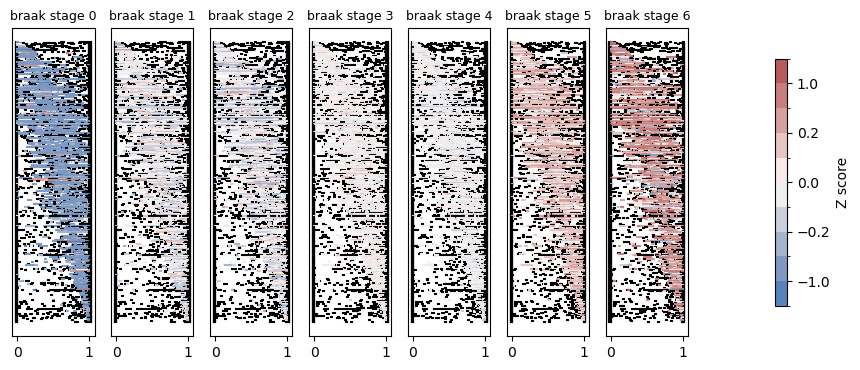

In [209]:
pos = 0

fig, axes = plt.subplots(ncols = 8, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 1, 1, 1]})

colores = sns.color_palette("vlag", 10)
for idx, row in order_df.sort_values('position').iterrows():
    gene = row.gene
    strand = row.strand
    gencode_bed, gencode_full_gene = get_gencode_bed(gencode, gene)
    gencode_bed = gencode_bed.to_dataframe()
    start_ = gencode_bed.end.iloc[0]
    end_ = gencode_bed.start.iloc[-1]


    for i in range(7):
        axes[i].plot([-0.02, 0], [pos, pos], c='black')
        axes[i].plot([1, 1.02], [pos, pos], c='black')
        
    if gencode_bed.shape[0] >= 3:

        for idx, row in gencode_bed.iloc[1:-1].iterrows():
            ex_start = (row.start - start_)/(end_ - start_)
            ex_end = (row.end - start_)/(end_ - start_)
            if strand == '-':
                ex_start = 1-ex_start
                ex_end = 1-ex_end
            for i in range(7):
                axes[i].plot([ex_start, ex_end], [pos, pos], c='black')


    for idx, row in introns_bed.loc[introns_bed.gene == gene].iterrows():
        int_start = (row.start - start_)/(end_ - start_)
        int_end = (row.end - start_)/(end_ - start_)
        if strand == '-':
            int_start = 1 - int_start
            int_end = 1 - int_end
        for i in range(7):
            col_score = row[f'braaks_{str(i)}_zloadings.PCC']
            axes[i].plot([int_start, int_end], [pos, pos], c=select_color(col_score, colores))
    pos -= 1

for i in range(7):
    axes[i].set_yticks([])
    axes[i].set_title(f'braak stage {str(i)}', size=9)

cmap = mcolors.ListedColormap(colores)
norm = mcolors.BoundaryNorm(np.arange(len(colores)+1)-0.5, len(colores))

# Create a scatter plot

axes[7].spines[['top', 'bottom', 'right', 'left']].set_visible(False)
axes[7].set_xticks([])
axes[7].set_yticks([])
# axes[7].set_ylim([pos, 0])

# Add a colorbar
add_vertical_colorbar_to_ax(axes[7], colores)
plt.show()

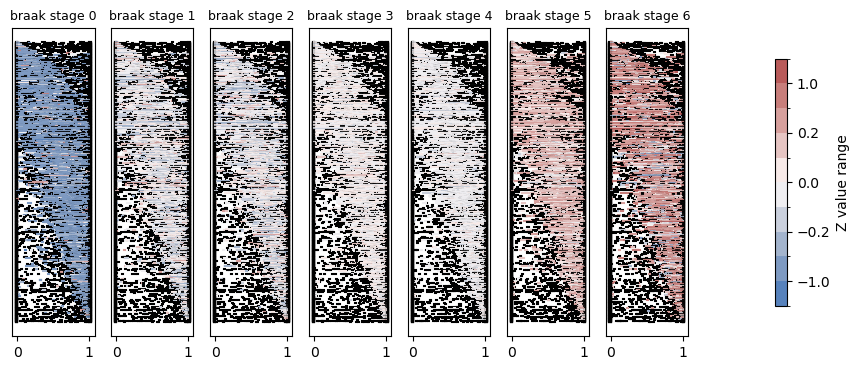

In [485]:
pos = 0

fig, axes = plt.subplots(ncols = 8, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 1, 1, 1]})

colores = sns.color_palette("vlag", 10)
for idx, row in order_df.sort_values('position').iterrows():
    gene = row.gene
    strand = row.strand
    gencode_bed, gencode_full_gene = get_gencode_bed(gencode, gene)
    gencode_bed = gencode_bed.to_dataframe()
    start_ = gencode_bed.end.iloc[0]
    end_ = gencode_bed.start.iloc[-1]


    for i in range(7):
        axes[i].plot([-0.02, 0], [pos, pos], c='black')
        axes[i].plot([1, 1.02], [pos, pos], c='black')
        
    if gencode_bed.shape[0] >= 3:

        for idx, row in gencode_bed.iloc[1:-1].iterrows():
            ex_start = (row.start - start_)/(end_ - start_)
            ex_end = (row.end - start_)/(end_ - start_)
            if strand == '-':
                ex_start = 1-ex_start
                ex_end = 1-ex_end
            for i in range(7):
                axes[i].plot([ex_start, ex_end], [pos, pos], c='black')


    for idx, row in introns_bed.loc[introns_bed.gene == gene].iterrows():
        int_start = (row.start - start_)/(end_ - start_)
        int_end = (row.end - start_)/(end_ - start_)
        if strand == '-':
            int_start = 1 - int_start
            int_end = 1 - int_end
        for i in range(7):
            col_score = row[f'braaks_{str(i)}_zloadings.PCC']
            axes[i].plot([int_start, int_end], [pos, pos], c=select_color(col_score, colores))
    pos -= 1

for i in range(7):
    axes[i].set_yticks([])
    axes[i].set_title(f'braak stage {str(i)}', size=9)

cmap = mcolors.ListedColormap(colores)
norm = mcolors.BoundaryNorm(np.arange(len(colores)+1)-0.5, len(colores))

# Create a scatter plot

axes[7].spines[['top', 'bottom', 'right', 'left']].set_visible(False)
axes[7].set_xticks([])
axes[7].set_yticks([])
# axes[7].set_ylim([pos, 0])

# Add a colorbar
add_vertical_colorbar_to_ax(axes[7], colores)
plt.show()

In [295]:
from scipy.stats import pearsonr, spearmanr
braaks_loadings_cols = [f'braaks_{str(i)}_loadings' for i in range(7)]
corr_list = []
gene_list = []
for gene, row in introns_bed.groupby('gene')[braaks_loadings_cols].mean().iterrows():
    corr_list.append(pearsonr(np.arange(7), list(row))[0])
    gene_list.append(gene)

gene_corr = pd.DataFrame()
gene_corr['gene'] = gene_list
gene_corr['correlation'] = corr_list

In [296]:
order_df = order_df.merge(gene_corr, right_on='gene', left_on='gene')

In [297]:
(gene_corr.correlation >= 0).mean()

0.9135559921414538

In [373]:
order_df.position.median()

0.6588866807793666

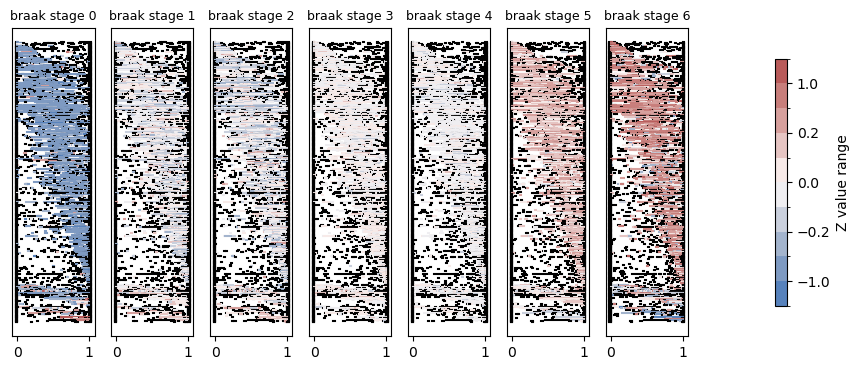

In [283]:
pos = 0

fig, axes = plt.subplots(ncols = 8, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 1, 1, 1]})

colores = sns.color_palette("vlag", 10)
for idx, row in order_df.loc[(order_df.correlation > 0.3)].sort_values('position').iterrows():
    gene = row.gene
    strand = row.strand
    gencode_bed, gencode_full_gene = get_gencode_bed(gencode, gene)
    gencode_bed = gencode_bed.to_dataframe()
    start_ = gencode_bed.end.iloc[0]
    end_ = gencode_bed.start.iloc[-1]


    for i in range(7):
        axes[i].plot([-0.02, 0], [pos, pos], c='black')
        axes[i].plot([1, 1.02], [pos, pos], c='black')
        
    if gencode_bed.shape[0] >= 3:

        for idx, row in gencode_bed.iloc[1:-1].iterrows():
            ex_start = (row.start - start_)/(end_ - start_)
            ex_end = (row.end - start_)/(end_ - start_)
            if strand == '-':
                ex_start = 1-ex_start
                ex_end = 1-ex_end
            for i in range(7):
                axes[i].plot([ex_start, ex_end], [pos, pos], c='black')


    for idx, row in introns_bed.loc[introns_bed.gene == gene].iterrows():
        int_start = (row.start - start_)/(end_ - start_)
        int_end = (row.end - start_)/(end_ - start_)
        if strand == '-':
            int_start = 1 - int_start
            int_end = 1 - int_end
        for i in range(7):
            col_score = row[f'braaks_{str(i)}_zloadings.PCC']
            axes[i].plot([int_start, int_end], [pos, pos], c=select_color(col_score, colores))
    pos -= 1




for idx, row in order_df.loc[(order_df.correlation <= 0.3) & (order_df.correlation >= -0.3)].sort_values('position').iterrows():
    gene = row.gene
    strand = row.strand
    gencode_bed, gencode_full_gene = get_gencode_bed(gencode, gene)
    gencode_bed = gencode_bed.to_dataframe()
    start_ = gencode_bed.end.iloc[0]
    end_ = gencode_bed.start.iloc[-1]


    for i in range(7):
        axes[i].plot([-0.02, 0], [pos, pos], c='black')
        axes[i].plot([1, 1.02], [pos, pos], c='black')
        
    if gencode_bed.shape[0] >= 3:

        for idx, row in gencode_bed.iloc[1:-1].iterrows():
            ex_start = (row.start - start_)/(end_ - start_)
            ex_end = (row.end - start_)/(end_ - start_)
            if strand == '-':
                ex_start = 1-ex_start
                ex_end = 1-ex_end
            for i in range(7):
                axes[i].plot([ex_start, ex_end], [pos, pos], c='black')


    for idx, row in introns_bed.loc[introns_bed.gene == gene].iterrows():
        int_start = (row.start - start_)/(end_ - start_)
        int_end = (row.end - start_)/(end_ - start_)
        if strand == '-':
            int_start = 1 - int_start
            int_end = 1 - int_end
        for i in range(7):
            col_score = row[f'braaks_{str(i)}_zloadings.PCC']
            axes[i].plot([int_start, int_end], [pos, pos], c=select_color(col_score, colores))
    pos -= 1




for idx, row in order_df.loc[(order_df.correlation < -0.3)].sort_values('position').iterrows():
    gene = row.gene
    strand = row.strand
    gencode_bed, gencode_full_gene = get_gencode_bed(gencode, gene)
    gencode_bed = gencode_bed.to_dataframe()
    start_ = gencode_bed.end.iloc[0]
    end_ = gencode_bed.start.iloc[-1]


    for i in range(7):
        axes[i].plot([-0.02, 0], [pos, pos], c='black')
        axes[i].plot([1, 1.02], [pos, pos], c='black')
        
    if gencode_bed.shape[0] >= 3:

        for idx, row in gencode_bed.iloc[1:-1].iterrows():
            ex_start = (row.start - start_)/(end_ - start_)
            ex_end = (row.end - start_)/(end_ - start_)
            if strand == '-':
                ex_start = 1-ex_start
                ex_end = 1-ex_end
            for i in range(7):
                axes[i].plot([ex_start, ex_end], [pos, pos], c='black')


    for idx, row in introns_bed.loc[introns_bed.gene == gene].iterrows():
        int_start = (row.start - start_)/(end_ - start_)
        int_end = (row.end - start_)/(end_ - start_)
        if strand == '-':
            int_start = 1 - int_start
            int_end = 1 - int_end
        for i in range(7):
            col_score = row[f'braaks_{str(i)}_zloadings.PCC']
            axes[i].plot([int_start, int_end], [pos, pos], c=select_color(col_score, colores))
    pos -= 1




for i in range(7):
    axes[i].set_yticks([])
    axes[i].set_title(f'braak stage {str(i)}', size=9)

cmap = mcolors.ListedColormap(colores)
norm = mcolors.BoundaryNorm(np.arange(len(colores)+1)-0.5, len(colores))

# Create a scatter plot

axes[7].spines[['top', 'bottom', 'right', 'left']].set_visible(False)
axes[7].set_xticks([])
axes[7].set_yticks([])
# axes[7].set_ylim([pos, 0])

# Add a colorbar
add_vertical_colorbar_to_ax(axes[7], colores)
plt.show()

In [490]:
coverage_zmean = introns_bed.groupby(['gene'])[[f'braaks_{str(i)}_zloadings.PCC' for i in range(7)]].mean()

In [491]:
import random
from sklearn.cluster import KMeans

In [492]:
random.seed(0)
KM = KMeans().fit(coverage_zmean)

In [493]:
km_labels = KM.labels_

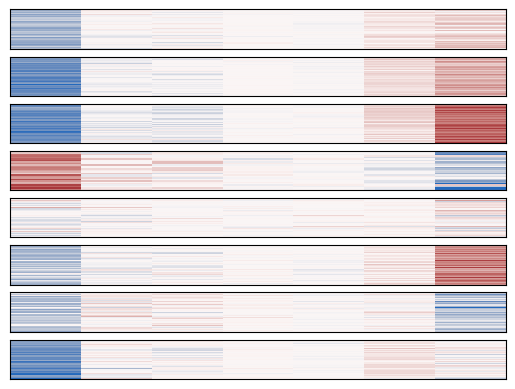

In [495]:
fig, axes = plt.subplots(nrows=8)#, gridspec_kw={'height_ratios':height_ratios, 'hspace':0.05})
for i in range(8):
    slice_zmean = coverage_zmean.loc[KM.labels_ == i]
    sns.heatmap(slice_zmean, ax=axes[i], cmap='vlag', vmin=-1, vmax=1, cbar=False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].spines[['top', 'right', 'left', 'bottom']].set_visible(True)

In [503]:
gvc1 = pd.read_csv('../code/GVC_table1.tsv', sep='\t', skiprows=2, names = ['number', 'chrom', 'location', 'snv', 'gene'])
gvc2 = pd.read_csv('../code/GVC_table2.tsv', sep='\t', skiprows=2, names = ['number', 'gene', 'source', 'location'])
ru_extended = pd.read_csv('../code/overlap.min_corr_gwas95_qtl70.genelist.csv')

ad_genes_ru = pd.Index(gvc1.gene).union(pd.Index(gvc2.gene))
ad_gene_ru_id = pd.Index(genes_df.loc[genes_df.gene_name.isin(ad_genes_ru)].gene_id)

In [508]:
i_order = [2, 1, 5, 0, 7, 6, 4, 3]
height_ratios = [(km_labels == i).mean() for i in i_order]

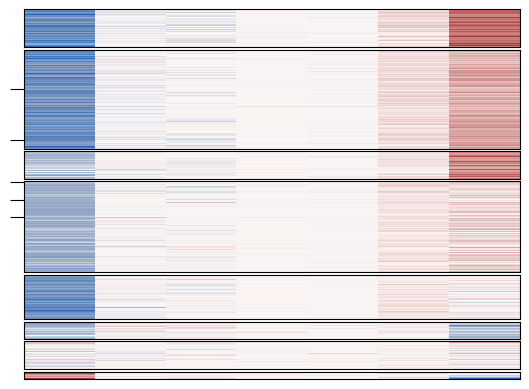

In [526]:
fig, axes = plt.subplots(nrows=8, gridspec_kw={'height_ratios':height_ratios, 'hspace':0.05})
for i in range(8):
    slice_zmean = coverage_zmean.loc[KM.labels_ == i_order[i]]
    sns.heatmap(slice_zmean, ax=axes[i], cmap='vlag', vmin=-1, vmax=1, cbar=False)
    if len(ad_gene_ru_id.intersection(coverage_zmean.loc[km_labels == i_order[i]].index)) > 0:
        idx = np.arange(len(coverage_zmean.loc[km_labels == i_order[i]].index))
        ru_idx = idx[pd.Series(coverage_zmean.loc[km_labels == i_order[i]].index).isin(ad_gene_ru_id)]
        axes[i].set_yticks(ru_idx)
    else:
        axes[i].set_yticks([])
    axes[i].set_xticks([])

    axes[i].tick_params(axis='both', which='major', length=10)
    
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].spines[['top', 'right', 'left', 'bottom']].set_visible(True)

In [510]:
for i, tick in enumerate(ax.get_xticklines()):
    if i % 2 == 0:
        tick.set_color('red')   # Set every other tick to red
    else:
        tick.set_color('blue')  # Set alternate ticks to blue

In [522]:
range()pd.Index(slice_zmean.index).isin(ad_gene_ru_id)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [438]:
ad_gene_ru_id.intersection(coverage_zmean.loc[km_labels == 2].index)

Index(['ENSG00000186815', 'ENSG00000120899'], dtype='object')

In [313]:
aver = ad_boxplot.groupby(['gene', 'isoform']).beta.mean().reset_index().merge(order_df, left_on='gene', right_on='gene')

In [325]:
np.sum(aver.loc[aver.correlation <= 0].beta >= 0) + np.sum(aver.loc[aver.correlation >= 0].beta <= 0)

51

In [326]:
51/aver.shape[0]

0.10019646365422397

In [332]:
len(introns_bed.gene.unique())

509

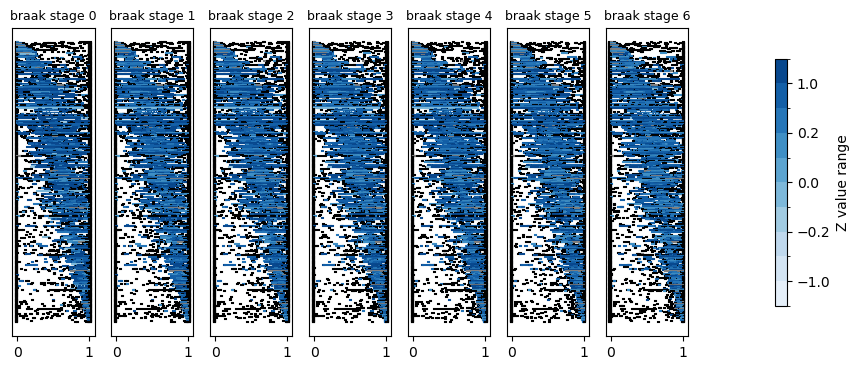

In [216]:
pos = 0

fig, axes = plt.subplots(ncols = 8, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 1, 1, 1]})

colores = sns.color_palette("Blues", 10)
for idx, row in order_df.sort_values('position').iterrows():
    gene = row.gene
    strand = row.strand
    gencode_bed, gencode_full_gene = get_gencode_bed(gencode, gene)
    gencode_bed = gencode_bed.to_dataframe()
    start_ = gencode_bed.end.iloc[0]
    end_ = gencode_bed.start.iloc[-1]


    for i in range(7):
        axes[i].plot([-0.02, 0], [pos, pos], c='black')
        axes[i].plot([1, 1.02], [pos, pos], c='black')
        
    if gencode_bed.shape[0] >= 3:

        for idx, row in gencode_bed.iloc[1:-1].iterrows():
            ex_start = (row.start - start_)/(end_ - start_)
            ex_end = (row.end - start_)/(end_ - start_)
            if strand == '-':
                ex_start = 1-ex_start
                ex_end = 1-ex_end
            for i in range(7):
                axes[i].plot([ex_start, ex_end], [pos, pos], c='black')


    for idx, row in introns_bed.loc[introns_bed.gene == gene].iterrows():
        int_start = (row.start - start_)/(end_ - start_)
        int_end = (row.end - start_)/(end_ - start_)
        if strand == '-':
            int_start = 1 - int_start
            int_end = 1 - int_end
        for i in range(7):
            col_score = row[f'braaks_{str(i)}_loadings.PCC']
            axes[i].plot([int_start, int_end], [pos, pos], c=select_color_01(col_score, colores))
    pos -= 1

for i in range(7):
    axes[i].set_yticks([])
    axes[i].set_title(f'braak stage {str(i)}', size=9)

cmap = mcolors.ListedColormap(colores)
norm = mcolors.BoundaryNorm(np.arange(len(colores)+1)-0.5, len(colores))

# Create a scatter plot

axes[7].spines[['top', 'bottom', 'right', 'left']].set_visible(False)
axes[7].set_xticks([])
axes[7].set_yticks([])
# axes[7].set_ylim([pos, 0])

# Add a colorbar
add_vertical_colorbar_to_ax(axes[7], colores)
plt.show()

In [250]:
(introns_bed[f'braaks_5_loadings.PCC'] - introns_bed[f'braaks_0_loadings.PCC']).mean()

0.026894770758185377

In [194]:
gencode.loc[gencode.gene == 'ENSG00000146416']
gencode.loc[gencode.gene == 'ENSG00000146416'].strand.iloc[0]

'+'

In [185]:
gencode_bed, gencode_full_gene = get_gencode_bed(gencode, 'ENSG00000146416')
gencode_bed = gencode_bed.to_dataframe()

In [186]:
gencode_bed

,chrom,start,end
0,chr6,143060889,143061066
1,chr6,143136835,143136990
2,chr6,143165082,143165183
3,chr6,143284110,143284225
4,chr6,143333282,143333445
5,chr6,143339639,143341058


In [163]:
introns_bed_ = introns_bed.loc[introns_bed.gene == 'ENSG00000000460']
gencode_bed, gencode_full_gene = get_gencode_bed(gencode, 'ENSG00000000460')
gencode_bed = gencode_bed.to_dataframe()

In [170]:
1 - ((introns_bed_.start - gencode_bed.end.iloc[0])/(gencode_bed.start.iloc[-1] - gencode_bed.end.iloc[0]))

0    0.857911
1    0.809727
2    0.777807
3    0.538015
4    0.508314
5    0.432579
6    0.404681
7    0.389215
Name: start, dtype: float64

In [171]:
1 - ((introns_bed_.end - gencode_bed.end.iloc[0])/(gencode_bed.start.iloc[-1] - gencode_bed.end.iloc[0]))

0    0.844664
1    0.780234
2    0.539436
3    0.509458
4    0.446294
5    0.407941
6    0.390672
7    0.383095
Name: end, dtype: float64

In [141]:
def add_vertical_colorbar_to_ax(ax, colores):
    # Create a custom colormap and norm for the colorbar
    cmap = ListedColormap(colores)
    bounds = [-1.5, -1, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1, 1.5]
    norm = BoundaryNorm(bounds, cmap.N)

    # Add the colorbar to the right of the ax, vertically
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        ax=ax, orientation='vertical', boundaries=bounds, pad=0.1
    )
    cbar.set_label('Z score')


In [128]:
colores = sns.color_palette("vlag", 10)
def select_color(z, colores):
    if z <= -1:
        out_color = colores[0]
    elif z <= -0.5:
        out_color = colores[1]
    elif z <= -0.2:
        out_color = colores[2]
    elif z <= -0.1:
        out_color = colores[3]
    elif z <= 0:
        out_color = colores[4]
    elif z >= 1:
        out_color = colores[9]
    elif z >= 0.5:
        out_color = colores[8]
    elif z >= 0.2:
        out_color = colores[7]
    elif z >= 0.1:
        out_color = colores[6]
    elif z > 0.0:
        out_color = colores[5]
    else:
        out_color = 'gray'
    return out_color

In [105]:
introns_bed.loc[introns_bed.gene == 'ENSG00000000460']

,chrom,start,end,gene,isoform,braaks_0_loadings,braaks_0_zloadings,braaks_1_loadings,braaks_1_zloadings,braaks_2_loadings,...,ad_loadings.AC,ad_zloadings.AC,ctrl_loadings.DLPC,ctrl_zloadings.DLPC,ad_loadings.DLPC,ad_zloadings.DLPC,ctrl_loadings.PCC,ctrl_zloadings.PCC,ad_loadings.PCC,ad_zloadings.PCC
0,chr1,169803310,169804074,ENSG00000000460,ENSG00000000460.isoform_3,0.036025,-0.318603,0.050907,-0.013301,0.054710,...,0.042399,0.017652,0.057229,-0.022299,0.059416,0.016375,0.062405,-0.024867,0.064518,0.014423
1,chr1,169806089,169807790,ENSG00000000460,ENSG00000000460.isoform_3,0.130326,-0.063127,0.142141,0.054241,0.157457,...,0.102725,-0.083544,0.183348,0.018518,0.198180,0.140213,0.168130,0.044436,0.156941,-0.060286
2,chr1,169807930,169821678,ENSG00000000460,ENSG00000000460.isoform_3,0.190492,-0.077116,0.201992,0.003930,0.231965,...,0.161775,-0.015279,0.272952,0.151029,0.241420,-0.047391,0.240677,-0.013351,0.238866,-0.024337
3,chr1,169821760,169823407,ENSG00000000460,ENSG00000000460.isoform_3,0.076414,-0.200961,0.099640,0.002536,0.119938,...,0.078492,-0.035139,0.131004,0.059685,0.108171,-0.098869,0.121527,0.021620,0.117884,-0.005387
4,chr1,169823473,169827050,ENSG00000000460,ENSG00000000460.isoform_3,0.074052,0.029989,0.065164,-0.108074,0.071623,...,0.067305,0.048009,0.093856,0.108139,0.086010,-0.015881,0.078541,-0.015083,0.083467,0.064887
5,chr1,169827841,169829262,ENSG00000000460,ENSG00000000460.isoform_3,0.064638,-0.179841,0.082786,0.066796,0.068364,...,0.069750,0.042827,0.078176,-0.017922,0.083327,0.056898,0.100495,0.088292,0.081650,-0.120751
6,chr1,169829450,169830258,ENSG00000000460,ENSG00000000460.isoform_3,0.169831,0.158383,0.157417,0.056102,0.156526,...,0.128315,0.012816,0.204097,0.188379,0.172393,-0.080806,0.180174,0.031716,0.166713,-0.068456
7,chr1,169830342,169830695,ENSG00000000460,ENSG00000000460.isoform_3,0.203319,0.400170,0.112028,-0.152147,0.154992,...,0.097805,-0.109026,0.213684,0.144108,0.171397,-0.063660,0.146158,-0.065884,0.170140,0.076242


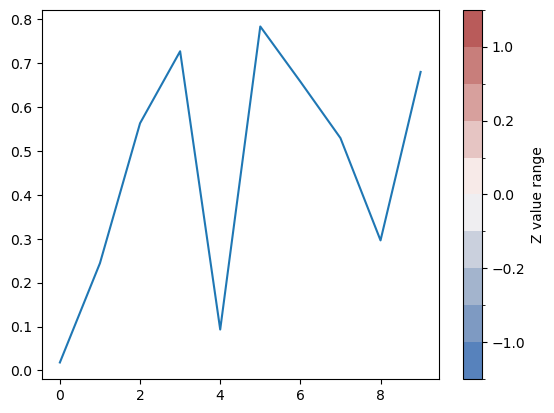

In [215]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define the color palette
colores = sns.color_palette("vlag", 10)

# Function to select the color based on z value
def select_color(z, colores):
    if z <= -1:
        out_color = colores[0]
    elif z <= -0.5:
        out_color = colores[1]
    elif z <= -0.2:
        out_color = colores[2]
    elif z <= -0.1:
        out_color = colores[3]
    elif z <= 0:
        out_color = colores[4]
    elif z >= 1:
        out_color = colores[9]
    elif z >= 0.5:
        out_color = colores[8]
    elif z >= 0.2:
        out_color = colores[7]
    elif z >= 0.1:
        out_color = colores[6]
    elif z > 0.0:
        out_color = colores[5]
    else:
        out_color = 'gray'
    return out_color


def select_color_01(z, colores):
    if z <= 1e-4:
        out_color = colores[0]
    elif z <= 5e-4:
        out_color = colores[1]
    elif z <= 1e-3:
        out_color = colores[2]
    elif z <= 5e-3:
        out_color = colores[3]
    elif z <= 1e-2:
        out_color = colores[4]
    elif z <= 5e-2:
        out_color = colores[9]
    elif z <= 1e-1:
        out_color = colores[8]
    elif z <= 0.2:
        out_color = colores[7]
    elif z <= 0.5:
        out_color = colores[6]
    elif z > 0.9:
        out_color = colores[5]
    else:
        out_color = 'gray'
    return out_color

# Function to add a vertical colorbar to the right of an existing axis
def add_vertical_colorbar_to_ax(ax, colores):
    # Create a custom colormap and norm for the colorbar
    cmap = ListedColormap(colores)
    bounds = [-1.5, -1, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1, 1.5]
    norm = BoundaryNorm(bounds, cmap.N)

    # Add the colorbar to the right of the ax, vertically
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        ax=ax, orientation='vertical', boundaries=bounds
    )
    cbar.set_label('Z value range')

# Example usage with any given axis (ax)
fig, ax = plt.subplots()

# Some sample content in the ax
ax.plot(np.random.rand(10))

# Add the vertical colorbar to the right of the existing ax
add_vertical_colorbar_to_ax(ax, colores)

plt.show()


In [344]:
introns_bed.gene.unique()

array(['ENSG00000000460', 'ENSG00000001497', 'ENSG00000036448',
       'ENSG00000044446', 'ENSG00000049246', 'ENSG00000062598',
       'ENSG00000068724', 'ENSG00000069849', 'ENSG00000074319',
       'ENSG00000075975', 'ENSG00000100142', 'ENSG00000102317',
       'ENSG00000103365', 'ENSG00000105499', 'ENSG00000106603',
       'ENSG00000107736', 'ENSG00000107798', 'ENSG00000108510',
       'ENSG00000108559', 'ENSG00000115687', 'ENSG00000116984',
       'ENSG00000121775', 'ENSG00000126773', 'ENSG00000127329',
       'ENSG00000128159', 'ENSG00000129159', 'ENSG00000130175',
       'ENSG00000131067', 'ENSG00000131653', 'ENSG00000134376',
       'ENSG00000135931', 'ENSG00000137275', 'ENSG00000142279',
       'ENSG00000142327', 'ENSG00000143442', 'ENSG00000144535',
       'ENSG00000145014', 'ENSG00000146416', 'ENSG00000147316',
       'ENSG00000148120', 'ENSG00000148362', 'ENSG00000148824',
       'ENSG00000149654', 'ENSG00000151575', 'ENSG00000152034',
       'ENSG00000153066', 'ENSG000001586

In [345]:
from tqdm import tqdm
for idx, df in tqdm(ad_boxplot.loc[ad_boxplot.FDR <= 1e-3].groupby(['gene', 'isoform']), position=0, leave=True):
    # try:
    if gene not in introns_bed.gene.unique():
        gene, isoform = idx
        gencode_bed, gencode_full_gene = get_gencode_bed(gencode, gene)
        torino_bed = BedTool.from_dataframe(isoforms.loc[isoforms.transcript_id == isoform])
        IR_bed = get_IR_bed(torino_bed, gencode_bed, gencode_full_gene)
    
        fh = gzip.open(f'../code/gao_data/counts/{gene}.csv.gz')
        coords = fh.readline()
        coords_int = [int(x.split(':')[1]) for x in coords.decode().rstrip().split(',')[1:]]
        intron_idx, meta_samples = get_plotting_averages2(isoform, IR_bed, metadata_test, coords_int, fh)
        list_of_rows = prepare_gene_df(intron_idx, meta_samples)
        fh.close()
    # except:
    #     break

100%|███████████████████████████████████████| 111/111 [00:00<00:00, 1171.11it/s]


In [364]:
from tqdm import tqdm
for idx, df in tqdm(ad_boxplot.loc[ad_boxplot.gene.isin(missing)].groupby(['gene', 'isoform']), position=0, leave=True):
    # try:
    
    gene, isoform = idx
    if gene not in introns_bed.gene.unique():
        gencode_bed, gencode_full_gene = get_gencode_bed(gencode, gene)
        torino_bed = BedTool.from_dataframe(isoforms.loc[isoforms.transcript_id == isoform])
        IR_bed = get_IR_bed(torino_bed, gencode_bed, gencode_full_gene)
    
        fh = gzip.open(f'../code/gao_data/counts/{gene}.csv.gz')
        coords = fh.readline()
        coords_int = [int(x.split(':')[1]) for x in coords.decode().rstrip().split(',')[1:]]
        intron_idx, meta_samples = get_plotting_averages2(isoform, IR_bed, metadata_test, coords_int, fh)
        list_of_rows = prepare_gene_df(intron_idx, meta_samples)
        fh.close()
    else:
        print('what?')
    # except:
    #     break

  0%|                                                    | 0/42 [00:00<?, ?it/s]


AttributeError: 'DataFrame' object has no attribute 'start'

In [365]:
get_IR_bed(torino_bed, gencode_bed, gencode_full_gene)

AttributeError: 'DataFrame' object has no attribute 'start'

In [368]:
torino_bed.intersect(gencode_full_gene, f=1).to_dataframe()#.subtract(gencode_bed).to_dataframe()

,chrom,start,end,name,score,strand,thickStart,thickEnd
0,chr1,19317600,19317841,ENSG00000040487,ENSG00000040487.isoform_2,+,factor_3,exon_2
1,chr1,19324633,19324762,ENSG00000040487,ENSG00000040487.isoform_2,+,factor_3,exon_3
2,chr1,19325495,19325582,ENSG00000040487,ENSG00000040487.isoform_2,+,factor_3,exon_4
3,chr1,19326245,19326387,ENSG00000040487,ENSG00000040487.isoform_2,+,factor_3,exon_5
4,chr1,19326531,19326623,ENSG00000040487,ENSG00000040487.isoform_2,+,factor_3,exon_6


In [369]:
gencode_bed.to_dataframe()

,chrom,start,end
0,chr1,19312326,19312889
1,chr1,19317600,19317841
2,chr1,19324633,19324762
3,chr1,19325495,19325582
4,chr1,19326245,19326387
5,chr1,19326531,19326623
6,chr1,19327227,19327412
7,chr1,19328572,19329300


In [359]:
missing = ad_boxplot.loc[(ad_boxplot.FDR <= 1e-3) & (ad_boxplot.gene.apply(lambda x: x not in introns_bed.gene.unique()))].gene.unique()

In [363]:
pd.Index(missing).intersection(pd.Index(introns_bed.gene.unique()))

Index([], dtype='object')

In [350]:
len(introns_bed.gene.unique())

509

In [348]:
len(ad_boxplot.loc[ad_boxplot.FDR <= 1e-3].gene.unique())

111

In [340]:
EL = pd.read_csv('../code/ebpmf_models/gao_models/tables/snmf5_EL.tab.gz', sep='\t', index_col=3)


samples = EL.columns[5:]

metadata = pd.read_csv('../code/gao_data/metadata/merged_metadata.tab.gz', sep='\t', index_col=0)

X = EL[EL.columns[5:]]

metadata_test = metadata.loc[EL.columns.intersection(metadata.index)]

In [ ]:
c2_alzheimer = pd.read_csv()

In [28]:
ir_gene_list = []

for gene, row in tqdm(ad_pvals.iterrows(), leave=True, position = 0):
    try:
        x = row.loc[[f'factor_{str(i+1)}' for i in range(5)]]
        min_factors = x.index
        min_factor = x.index[x.argmin()]

        aver = isoforms.loc[(isoforms.gene_id == gene) & (isoforms.factor.apply(lambda x: min_factor in x))].transcript_id.iloc[0]
        
        is_ir = (second_annot.loc[second_annot.transcript_id == aver].intron_retention.isin(['unannotated.intron_retention', 'annotated.intron_retention'])).sum()
        
        first_min = x.min()
        second_min_factor = x[x != first_min].idxmin()

        
        # for min_factor in min_factors:
        aver = isoforms.loc[(isoforms.gene_id == gene) & (isoforms.factor.apply(lambda x: second_min_factor in x))].transcript_id.iloc[0]
        
        is_ir += (second_annot.loc[second_annot.transcript_id == aver].intron_retention.isin(['unannotated.intron_retention', 'annotated.intron_retention'])).sum()
        if is_ir >= 1:
            ir_gene_list.append(gene)

        
    except:
        continue

15232it [53:02,  4.79it/s]


In [31]:
ir_gene_list

['ENSG00000148123',
 'ENSG00000250565',
 'ENSG00000157193',
 'ENSG00000176155',
 'ENSG00000066468',
 'ENSG00000225973',
 'ENSG00000111711',
 'ENSG00000042286',
 'ENSG00000164414',
 'ENSG00000205209',
 'ENSG00000101935',
 'ENSG00000198721',
 'ENSG00000178752',
 'ENSG00000092208',
 'ENSG00000151577',
 'ENSG00000143153',
 'ENSG00000162241',
 'ENSG00000096996',
 'ENSG00000175048',
 'ENSG00000182054',
 'ENSG00000213626',
 'ENSG00000065613',
 'ENSG00000165025',
 'ENSG00000177599',
 'ENSG00000260914',
 'ENSG00000279983',
 'ENSG00000155307',
 'ENSG00000187980',
 'ENSG00000174799',
 'ENSG00000268614',
 'ENSG00000153237',
 'ENSG00000169715',
 'ENSG00000111850',
 'ENSG00000157978',
 'ENSG00000180089',
 'ENSG00000135245',
 'ENSG00000167986',
 'ENSG00000173261',
 'ENSG00000226124',
 'ENSG00000154493',
 'ENSG00000082397',
 'ENSG00000134716',
 'ENSG00000100129',
 'ENSG00000130829',
 'ENSG00000165102',
 'ENSG00000009830',
 'ENSG00000162931',
 'ENSG00000243989',
 'ENSG00000123179',
 'ENSG00000180739',


In [33]:
with open('../code/ebpmf_models/gao_models/tables/ir_genes.txt', 'w') as fh:
    for gene in ir_gene_list:
        fh.write(gene + '\n')

In [34]:
ir_gene_list = []

for gene, row in tqdm(ad_pvals.iterrows(), leave=True, position = 0):
    try:
        x = row.loc[[f'factor_{str(i+1)}' for i in range(5)]]
        min_factors = x.index
        min_factor = x.index[x.argmin()]

        aver = isoforms.loc[(isoforms.gene_id == gene) & (isoforms.factor.apply(lambda x: min_factor in x))].transcript_id.iloc[0]
        
        is_ir = (second_annot.loc[second_annot.transcript_id == aver].intron_retention.isin(['unannotated.intron_retention', 'annotated.intron_retention'])).sum()
        
        # first_min = x.min()
        # second_min_factor = x[x != first_min].idxmin()

        
        # # for min_factor in min_factors:
        # aver = isoforms.loc[(isoforms.gene_id == gene) & (isoforms.factor.apply(lambda x: second_min_factor in x))].transcript_id.iloc[0]
        
        # is_ir += (second_annot.loc[second_annot.transcript_id == aver].intron_retention.isin(['unannotated.intron_retention', 'annotated.intron_retention'])).sum()
        if is_ir >= 1:
            ir_gene_list.append(gene)

        
    except:
        continue

15232it [26:11,  9.70it/s]
